In [ ]:
import os
import shutil

# Define source and destination folders
image_src = '/workspace/data/final_split_balanced/augmentedtrain/images'
mask_src = '/workspace/data/final_split_balanced/augmentedtrain/masks'
output_image_dir = '/workspace/data/final_split_balanced/filtered_data/images'
output_mask_dir = '/workspace/data/final_split_balanced/filtered_data/masks'

# Create destination folders if they don't exist
os.makedirs(output_image_dir, exist_ok=True)
os.makedirs(output_mask_dir, exist_ok=True)

def copy_filtered_files(src_dir, dest_dir):
    for filename in os.listdir(src_dir):
        full_path = os.path.join(src_dir, filename)

        # Skip directories like .ipynb_checkpoints
        if not os.path.isfile(full_path):
            continue

        # Skip files ending with _flip before extension
        name, ext = os.path.splitext(filename)
        if not name.endswith('_flip'):
            shutil.copy(full_path, os.path.join(dest_dir, filename))

# Copy images and masks
copy_filtered_files(image_src, output_image_dir)
copy_filtered_files(mask_src, output_mask_dir)

print("Filtered files copied successfully.")


Filtered files copied successfully.


In [ ]:
import os
import shutil

# List of target directories to check
paths = [
    "/workspace/final_split_balanced/final_split_balanced/augmentedtrain/images",
    "/workspace/final_split_balanced/final_split_balanced/augmentedtrain/images"
]

# Folder name to check for
target_folder = ".ipynb_checkpoints"

for path in paths:
    checkpoint_path = os.path.join(path, target_folder)
    if os.path.exists(checkpoint_path):
        print(f"Found and removing: {checkpoint_path}")
        shutil.rmtree(checkpoint_path)
    else:
        print(f"No checkpoint found in: {path}")


No checkpoint found in: /workspace/final_split_balanced/final_split_balanced/augmentedtrain/images
No checkpoint found in: /workspace/final_split_balanced/final_split_balanced/augmentedtrain/images


In [ ]:
!pip install opencv-python



[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import importlib.util
import cv2
import gc
from tensorflow.keras.callbacks import EarlyStopping

# === DICOMDataGen ===
class DICOMDataGen(tf.keras.utils.Sequence):
    def __init__(self, image_ids, img_path, mask_path, batch_size=4, image_size=512, shuffle=True):
        self.ids = image_ids
        self.img_path = img_path
        self.mask_path = mask_path
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __load__(self, item):
        image = cv2.imread(os.path.join(self.img_path, item), cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
        mask = cv2.imread(os.path.join(self.mask_path, item), cv2.IMREAD_GRAYSCALE).astype(np.float32)
        mask = (mask >= 255).astype(np.float32)

        image = cv2.resize(image, (self.image_size, self.image_size), interpolation=cv2.INTER_LINEAR)
        mask = cv2.resize(mask, (self.image_size, self.image_size), interpolation=cv2.INTER_NEAREST)

        return np.expand_dims(image, axis=-1), np.expand_dims(mask, axis=-1)

    def __getitem__(self, index):
        batch_ids = self.ids[index * self.batch_size : (index + 1) * self.batch_size]
        images, masks = zip(*(self.__load__(i) for i in batch_ids))
        return np.array(images), np.array(masks)

    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.ids)
        gc.collect()

    def __len__(self):
        return int(np.ceil(len(self.ids) / self.batch_size))


# === Metrics and Loss Functions ===
def dice_coef(y_true, y_pred):
    smooth = 1e-6
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1. - dice_coef(y_true, y_pred)

def iou_score(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    union = tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)


# === Compute Shape Prior ===
def compute_shape_prior_from_generator(generator):
    all_masks = []
    for i in range(len(generator)):
        _, masks = generator[i]
        all_masks.append(masks)
    all_masks = np.concatenate(all_masks, axis=0)
    prior = np.mean(all_masks, axis=0)  # shape: (H, W, 1)
    return prior


# === Custom Total Loss ===
def total_loss_fn(prior):
    prior_tensor = tf.convert_to_tensor(prior, dtype=tf.float32)
    def loss(y_true, y_pred):
        d_loss = dice_loss(y_true, y_pred)
        s_loss = tf.reduce_mean(tf.square(y_pred - prior_tensor))
        return d_loss + 0.1 * s_loss
    return loss


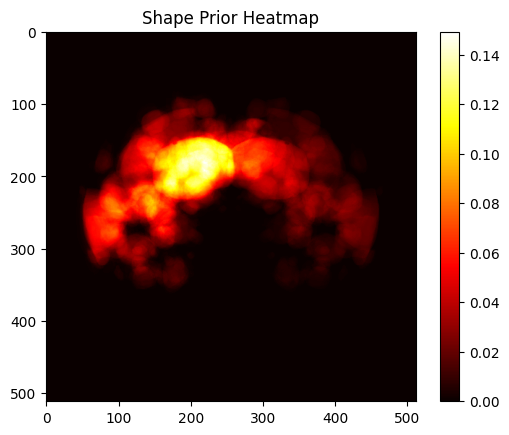

Pretrained weights loaded.
Frozen layers: ['conv00_1', 'conv00_2']
All other layers set to trainable
Epoch 1/50


2025-04-25 08:42:56.602196: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inUNetPP/X00_/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-04-25 08:42:57.537376: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8905
2025-04-25 08:42:57.604272: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-04-25 08:42:57.760890: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-04-25 08:43:00.360994: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x768590dfb220 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-04-25 08:43:00.361030: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX 6000 Ada Generation, Compute C

454/454 [==============================] - 89s 162ms/step - loss: 0.8488 - dice_coef: 0.1544 - iou_score: 0.0874 - val_loss: 0.8417 - val_dice_coef: 0.1609 - val_iou_score: 0.0910
Epoch 2/50
454/454 [==============================] - 66s 145ms/step - loss: 0.7929 - dice_coef: 0.2090 - iou_score: 0.1239 - val_loss: 0.8621 - val_dice_coef: 0.1405 - val_iou_score: 0.0778
Epoch 3/50
454/454 [==============================] - 67s 147ms/step - loss: 0.7500 - dice_coef: 0.2512 - iou_score: 0.1551 - val_loss: 0.8248 - val_dice_coef: 0.1758 - val_iou_score: 0.1003
Epoch 4/50
454/454 [==============================] - 72s 158ms/step - loss: 0.7132 - dice_coef: 0.2878 - iou_score: 0.1842 - val_loss: 0.8606 - val_dice_coef: 0.1429 - val_iou_score: 0.0795
Epoch 5/50
454/454 [==============================] - 66s 146ms/step - loss: 0.6720 - dice_coef: 0.3289 - iou_score: 0.2160 - val_loss: 0.9025 - val_dice_coef: 0.1064 - val_iou_score: 0.0573
Epoch 6/50
454/454 [==============================] - 67

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved to: /workspace/input_adapter_layers/shapeprior_input_adapter_freeze_firstlayer.h5


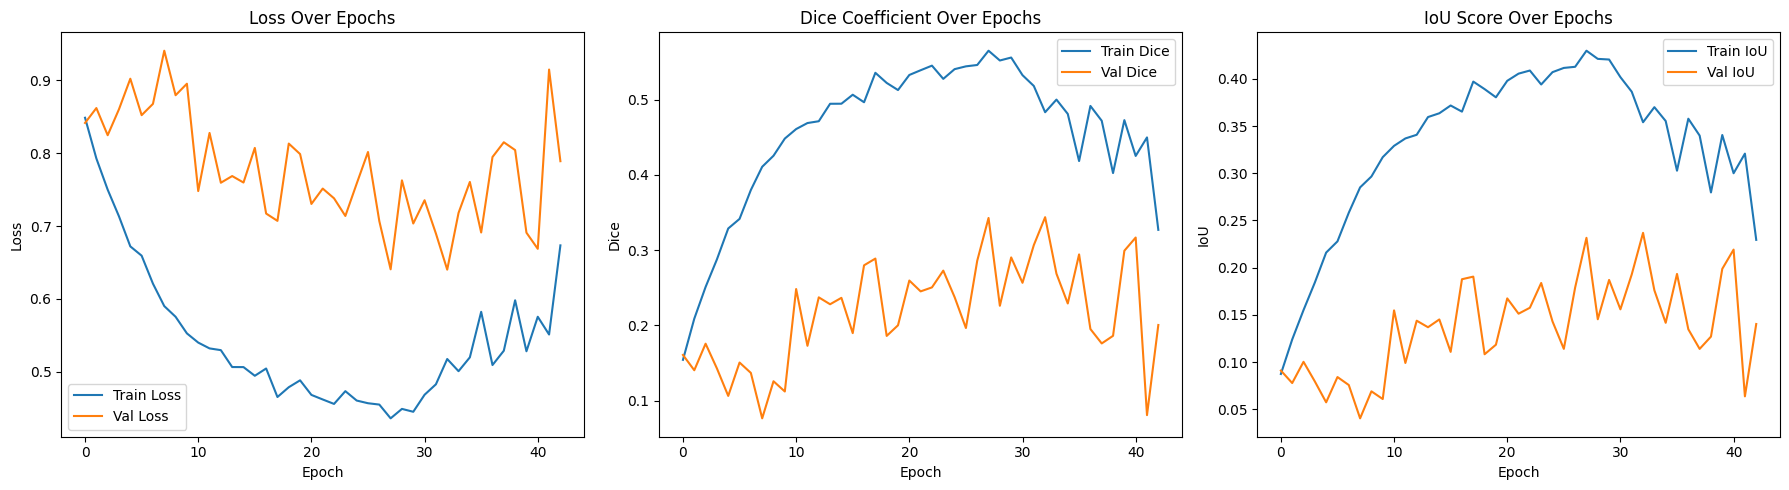

9352

In [ ]:
#freeze conv00
import importlib.util
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import gc

# === Load UNet++ with Input Adapter from the specified path ===
unetpp_path = "/workspace/unetpp_input_adapter_ct.py"
spec = importlib.util.spec_from_file_location("UNetPP", unetpp_path)
unetpp_module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(unetpp_module)
UNetPlusPlus = unetpp_module.UNetPlusPlus

# === Prepare Data Paths ===
train_img_path = "/workspace/final_split_balanced/final_split_balanced/augmentedtrain/images"
train_mask_path = "/workspace/final_split_balanced/final_split_balanced/augmentedtrain/masks"
valid_img_path = "/workspace/final_split_balanced/final_split_balanced/valid/images"
valid_mask_path = "/workspace/final_split_balanced/final_split_balanced/valid/masks"

train_image_ids = sorted(os.listdir(train_img_path))
valid_image_ids = sorted(os.listdir(valid_img_path))

# === Model Training Parameters ===
img_size = 512
batch_size = 4
epochs = 50
lr = 1e-4

# === Compute Shape Prior & Visualize ===
shape_prior = compute_shape_prior_from_generator(train_gen)

plt.imshow(shape_prior[..., 0], cmap='hot')
plt.title("Shape Prior Heatmap")
plt.colorbar()
plt.show()

# === Define Data Generators ===
# Assumes DICOMDataGen is already defined somewhere accessible
train_gen = DICOMDataGen(train_image_ids, train_img_path, train_mask_path, batch_size, img_size, shuffle=True)
valid_gen = DICOMDataGen(valid_image_ids, valid_img_path, valid_mask_path, batch_size, img_size, shuffle=False)

# === Build Model ===
input_shape = (img_size, img_size, 1)
unetpp_instance = UNetPlusPlus(input_shape=input_shape)
model = unetpp_instance.BuildNetwork()

# === Load pretrained weights ===
weights_path = "/workspace/UNetpp_BrainTumorSegment.h5"
model.load_weights(weights_path, by_name=True, skip_mismatch=True)
print("Pretrained weights loaded.")

# === Freeze only the first encoder layer (conv00) ===
frozen_layers = []
for layer in model.layers:
    if 'conv00' in layer.name:
        layer.trainable = False
        frozen_layers.append(layer.name)
    else:
        layer.trainable = True

print("Frozen layers:", frozen_layers)
print("All other layers set to trainable")

# === Compile model ===
optimizer = tf.keras.optimizers.Adam(learning_rate=lr, clipnorm=0.5)
model.compile(
    optimizer=optimizer,
    loss=total_loss_fn(shape_prior),  # total_loss_fn and shape_prior should be defined
    metrics=[dice_coef, iou_score]    # dice_coef and iou_score should be defined
)

# === Train model ===
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_dice_coef', mode='max', patience=10, restore_best_weights=True, verbose=1)
]

history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1
)

# === Save model ===
os.makedirs("/workspace/input_adapter_layers", exist_ok=True)
model_path = "/workspace/input_adapter_layers/shapeprior_input_adapter_freeze_firstlayer.h5"
model.save(model_path)
print(f"Model saved to: {model_path}")

# === Plot Training Curves ===
history_dict = history.history
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(history_dict['loss'], label='Train Loss')
plt.plot(history_dict['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history_dict['dice_coef'], label='Train Dice')
plt.plot(history_dict['val_dice_coef'], label='Val Dice')
plt.title('Dice Coefficient Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Dice')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history_dict['iou_score'], label='Train IoU')
plt.plot(history_dict['val_iou_score'], label='Val IoU')
plt.title('IoU Score Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()

plt.tight_layout()
plt.show()

# === Cleanup ===
tf.keras.backend.clear_session()
gc.collect()


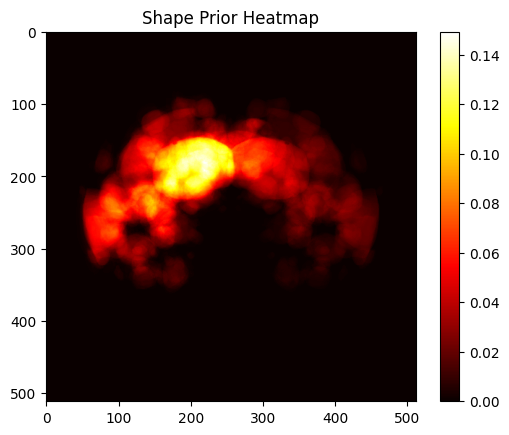

Pretrained weights loaded.
Frozen layers: ['conv00_1', 'conv00_2', 'conv10_1', 'conv10_2']
All other layers are set to trainable.
Epoch 1/50


2025-04-25 09:41:09.841196: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inUNetPP/X00_/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


454/454 [==============================] - 73s 143ms/step - loss: 0.8640 - dice_coef: 0.1395 - iou_score: 0.0777 - val_loss: 0.9748 - val_dice_coef: 0.0242 - val_iou_score: 0.0126
Epoch 2/50
454/454 [==============================] - 65s 143ms/step - loss: 0.8089 - dice_coef: 0.1931 - iou_score: 0.1131 - val_loss: 0.8677 - val_dice_coef: 0.1350 - val_iou_score: 0.0749
Epoch 3/50
454/454 [==============================] - 65s 143ms/step - loss: 0.7559 - dice_coef: 0.2452 - iou_score: 0.1515 - val_loss: 0.8017 - val_dice_coef: 0.1973 - val_iou_score: 0.1154
Epoch 4/50
454/454 [==============================] - 65s 143ms/step - loss: 0.7269 - dice_coef: 0.2740 - iou_score: 0.1733 - val_loss: 0.8442 - val_dice_coef: 0.1573 - val_iou_score: 0.0889
Epoch 5/50
454/454 [==============================] - 65s 143ms/step - loss: 0.7049 - dice_coef: 0.2960 - iou_score: 0.1911 - val_loss: 0.9067 - val_dice_coef: 0.1044 - val_iou_score: 0.0563
Epoch 6/50
454/454 [==============================] - 65

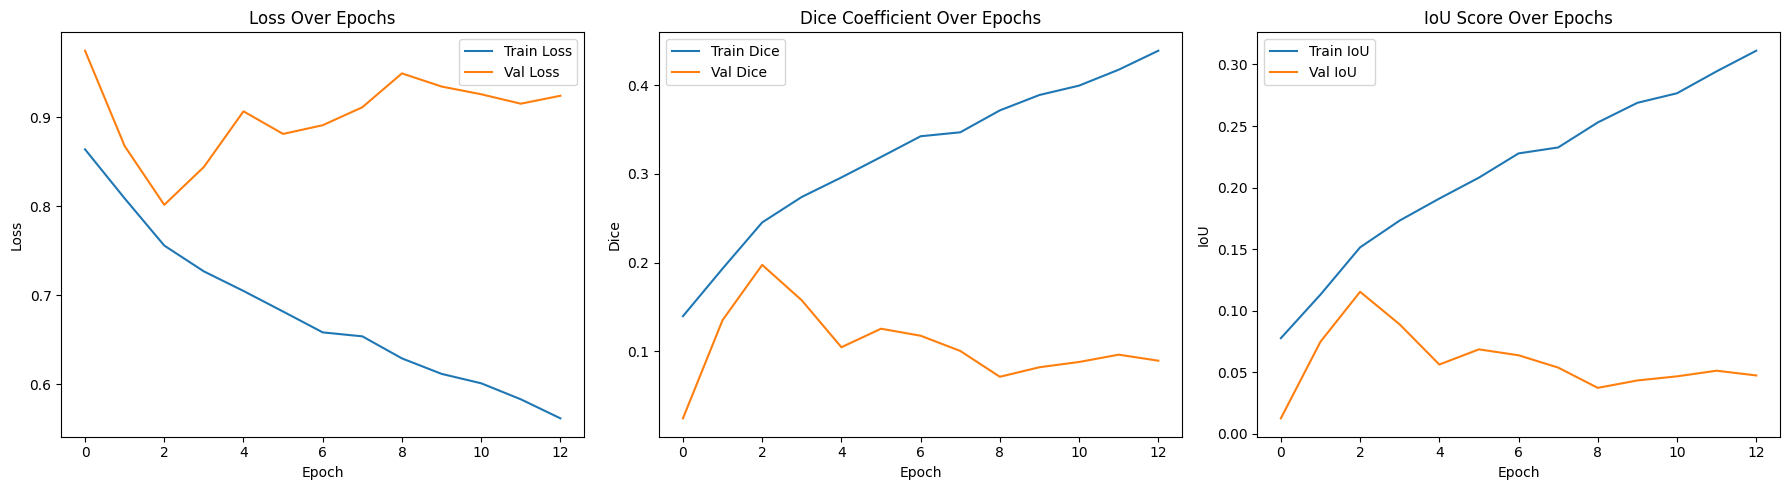

22177

In [ ]:
#freeze conv00 and conv10
import importlib.util
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import gc

# === Load UNet++ with Input Adapter from the specified path ===
unetpp_path = "/workspace/unetpp_input_adapter_ct.py"
spec = importlib.util.spec_from_file_location("UNetPP", unetpp_path)
unetpp_module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(unetpp_module)
UNetPlusPlus = unetpp_module.UNetPlusPlus

# === Prepare Data Paths ===
train_img_path = "/workspace/final_split_balanced/final_split_balanced/augmentedtrain/images"
train_mask_path = "/workspace/final_split_balanced/final_split_balanced/augmentedtrain/masks"
valid_img_path = "/workspace/final_split_balanced/final_split_balanced/valid/images"
valid_mask_path = "/workspace/final_split_balanced/final_split_balanced/valid/masks"

train_image_ids = sorted(os.listdir(train_img_path))
valid_image_ids = sorted(os.listdir(valid_img_path))

# === Model Training Parameters ===
img_size = 512
batch_size = 4
epochs = 50
lr = 1e-4

# === Compute Shape Prior & Visualize ===
shape_prior = compute_shape_prior_from_generator(train_gen)

plt.imshow(shape_prior[..., 0], cmap='hot')
plt.title("Shape Prior Heatmap")
plt.colorbar()
plt.show()

# === Define Data Generators ===
# Assumes DICOMDataGen is already defined somewhere accessible
train_gen = DICOMDataGen(train_image_ids, train_img_path, train_mask_path, batch_size, img_size, shuffle=True)
valid_gen = DICOMDataGen(valid_image_ids, valid_img_path, valid_mask_path, batch_size, img_size, shuffle=False)

# === Build Model ===
input_shape = (img_size, img_size, 1)
unetpp_instance = UNetPlusPlus(input_shape=input_shape)
model = unetpp_instance.BuildNetwork()

# === Load pretrained weights ===
weights_path = "/workspace/UNetpp_BrainTumorSegment.h5"
model.load_weights(weights_path, by_name=True, skip_mismatch=True)
print("Pretrained weights loaded.")

# === Freeze only first two encoder layers (conv00 and conv10) ===
for layer in model.layers:
    if any(name in layer.name for name in ['conv00', 'conv10']):
        layer.trainable = False
    else:
        layer.trainable = True

# === Print frozen layers for confirmation ===
frozen_layers = [layer.name for layer in model.layers if not layer.trainable]
print("Frozen layers:", frozen_layers)
print("All other layers are set to trainable.")


# === Compile model ===
optimizer = tf.keras.optimizers.Adam(learning_rate=lr, clipnorm=0.5)
model.compile(
    optimizer=optimizer,
    loss=total_loss_fn(shape_prior),  # total_loss_fn and shape_prior should be defined
    metrics=[dice_coef, iou_score]    # dice_coef and iou_score should be defined
)

# === Train model ===
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_dice_coef', mode='max', patience=10, restore_best_weights=True, verbose=1)
]

history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1
)

# === Save model ===
os.makedirs("/workspace/input_adapter_layers", exist_ok=True)
model_path = "/workspace/input_adapter_layers/shapeprior_input_adapter_freeze_twolayer.h5"
model.save(model_path)
print(f"Model saved to: {model_path}")

# === Plot Training Curves ===
history_dict = history.history
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(history_dict['loss'], label='Train Loss')
plt.plot(history_dict['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history_dict['dice_coef'], label='Train Dice')
plt.plot(history_dict['val_dice_coef'], label='Val Dice')
plt.title('Dice Coefficient Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Dice')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history_dict['iou_score'], label='Train IoU')
plt.plot(history_dict['val_iou_score'], label='Val IoU')
plt.title('IoU Score Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()

plt.tight_layout()
plt.show()

# === Cleanup ===
tf.keras.backend.clear_session()
gc.collect()


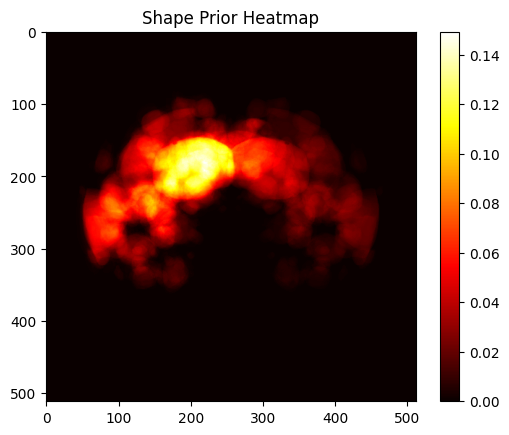

Pretrained weights loaded.
Frozen layers: ['conv00_1', 'conv00_2', 'conv10_1', 'conv10_2', 'conv20_1', 'conv20_2']
All other layers are set to trainable.
Epoch 1/50


2025-04-25 10:13:41.636497: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inUNetPP/X00_/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


454/454 [==============================] - 72s 143ms/step - loss: 0.8813 - dice_coef: 0.1219 - iou_score: 0.0676 - val_loss: 0.9019 - val_dice_coef: 0.1026 - val_iou_score: 0.0575
Epoch 2/50
454/454 [==============================] - 65s 142ms/step - loss: 0.8295 - dice_coef: 0.1719 - iou_score: 0.1007 - val_loss: 0.8519 - val_dice_coef: 0.1476 - val_iou_score: 0.0837
Epoch 3/50
454/454 [==============================] - 65s 143ms/step - loss: 0.7885 - dice_coef: 0.2124 - iou_score: 0.1300 - val_loss: 0.8800 - val_dice_coef: 0.1191 - val_iou_score: 0.0734
Epoch 4/50
454/454 [==============================] - 65s 143ms/step - loss: 0.7761 - dice_coef: 0.2248 - iou_score: 0.1403 - val_loss: 0.8218 - val_dice_coef: 0.1784 - val_iou_score: 0.1025
Epoch 5/50
454/454 [==============================] - 65s 143ms/step - loss: 0.7441 - dice_coef: 0.2567 - iou_score: 0.1643 - val_loss: 0.8203 - val_dice_coef: 0.1797 - val_iou_score: 0.1035
Epoch 6/50
454/454 [==============================] - 66

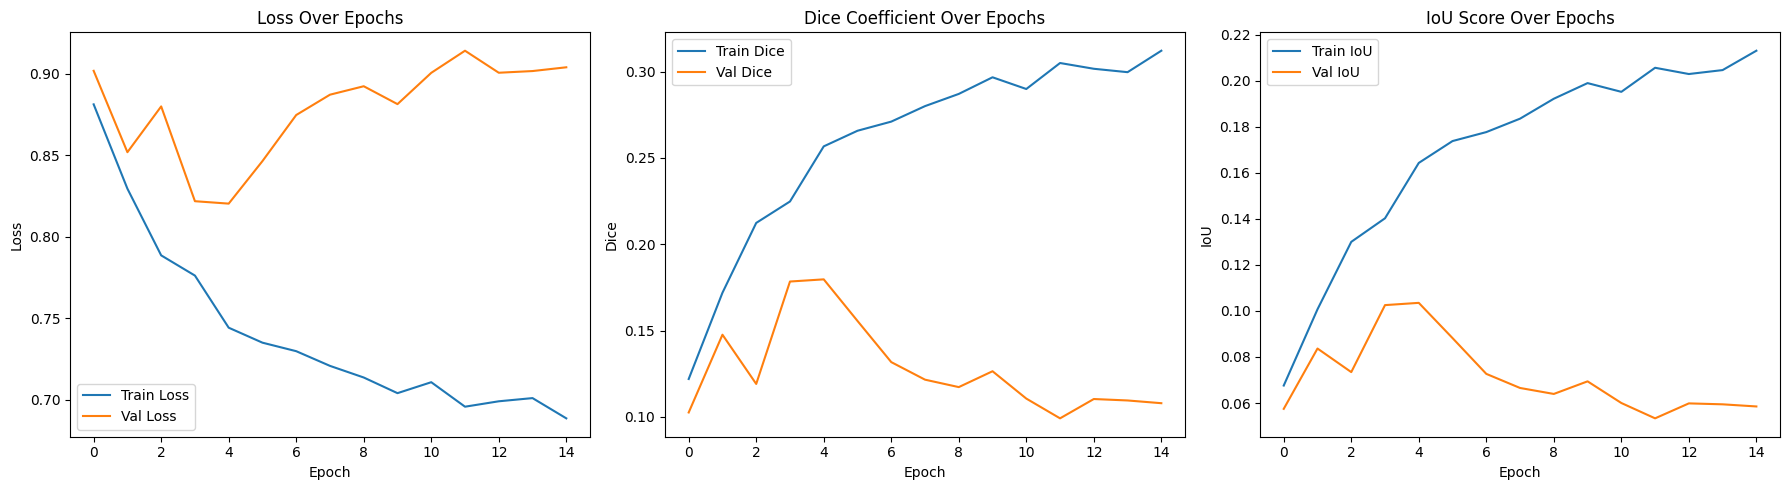

22848

In [ ]:
# Phase 3: Freeze conv00, conv10, conv20

import importlib.util
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import gc

# === Load UNet++ with Input Adapter from the specified path ===
unetpp_path = "/workspace/unetpp_input_adapter_ct.py"
spec = importlib.util.spec_from_file_location("UNetPP", unetpp_path)
unetpp_module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(unetpp_module)
UNetPlusPlus = unetpp_module.UNetPlusPlus

# === Prepare Data Paths ===
train_img_path = "/workspace/final_split_balanced/final_split_balanced/augmentedtrain/images"
train_mask_path = "/workspace/final_split_balanced/final_split_balanced/augmentedtrain/masks"
valid_img_path = "/workspace/final_split_balanced/final_split_balanced/valid/images"
valid_mask_path = "/workspace/final_split_balanced/final_split_balanced/valid/masks"

train_image_ids = sorted(os.listdir(train_img_path))
valid_image_ids = sorted(os.listdir(valid_img_path))

# === Model Training Parameters ===
img_size = 512
batch_size = 4
epochs = 50
lr = 1e-4

# === Compute Shape Prior & Visualize ===
shape_prior = compute_shape_prior_from_generator(train_gen)

plt.imshow(shape_prior[..., 0], cmap='hot')
plt.title("Shape Prior Heatmap")
plt.colorbar()
plt.show()

# === Define Data Generators ===
# Assumes DICOMDataGen is already defined somewhere accessible
train_gen = DICOMDataGen(train_image_ids, train_img_path, train_mask_path, batch_size, img_size, shuffle=True)
valid_gen = DICOMDataGen(valid_image_ids, valid_img_path, valid_mask_path, batch_size, img_size, shuffle=False)

# === Build Model ===
input_shape = (img_size, img_size, 1)
unetpp_instance = UNetPlusPlus(input_shape=input_shape)
model = unetpp_instance.BuildNetwork()

# === Load pretrained weights ===
weights_path = "/workspace/UNetpp_BrainTumorSegment.h5"
model.load_weights(weights_path, by_name=True, skip_mismatch=True)
print("Pretrained weights loaded.")

# === Freeze first three encoder layers (conv00, conv10, and conv20) ===
for layer in model.layers:
    if any(name in layer.name for name in ['conv00', 'conv10', 'conv20']):
        layer.trainable = False
    else:
        layer.trainable = True

# === Print frozen layers for confirmation ===
frozen_layers = [layer.name for layer in model.layers if not layer.trainable]
print("Frozen layers:", frozen_layers)
print("All other layers are set to trainable.")


# === Compile model ===
optimizer = tf.keras.optimizers.Adam(learning_rate=lr, clipnorm=0.5)
model.compile(
    optimizer=optimizer,
    loss=total_loss_fn(shape_prior),  # total_loss_fn and shape_prior should be defined
    metrics=[dice_coef, iou_score]    # dice_coef and iou_score should be defined
)

# === Train model ===
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_dice_coef', mode='max', patience=10, restore_best_weights=True, verbose=1)
]

history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1
)

# === Save model ===
os.makedirs("/workspace/input_adapter_layers", exist_ok=True)
model_path = "/workspace/input_adapter_layers/shapeprior_input_adapter_freeze_first_threelayer.h5"
model.save(model_path)
print(f"Model saved to: {model_path}")

# === Plot Training Curves ===
history_dict = history.history
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(history_dict['loss'], label='Train Loss')
plt.plot(history_dict['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history_dict['dice_coef'], label='Train Dice')
plt.plot(history_dict['val_dice_coef'], label='Val Dice')
plt.title('Dice Coefficient Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Dice')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history_dict['iou_score'], label='Train IoU')
plt.plot(history_dict['val_iou_score'], label='Val IoU')
plt.title('IoU Score Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()

plt.tight_layout()
plt.show()


# === Cleanup ===
tf.keras.backend.clear_session()
gc.collect()



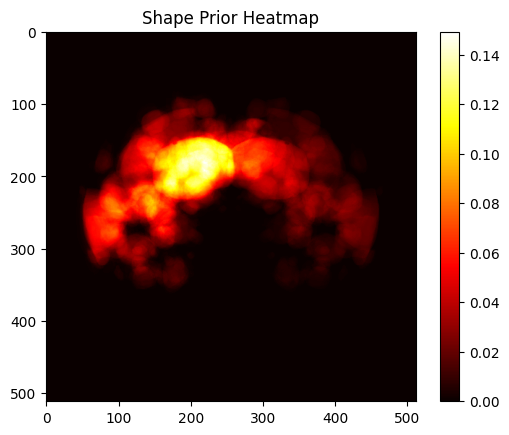

Pretrained weights loaded.
Frozen layers: ['conv00_1', 'conv00_2', 'conv10_1', 'conv10_2', 'conv20_1', 'conv20_2', 'conv30_1', 'conv30_2']
All other layers are set to trainable.
Epoch 1/50


2025-04-25 10:45:50.519423: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inUNetPP/X00_/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


454/454 [==============================] - 72s 143ms/step - loss: 1.0001 - dice_coef: 2.8452e-05 - iou_score: 1.4227e-05 - val_loss: 1.0001 - val_dice_coef: 2.3116e-10 - val_iou_score: 2.3116e-10
Epoch 2/50
454/454 [==============================] - 66s 145ms/step - loss: 0.9910 - dice_coef: 0.0097 - iou_score: 0.0050 - val_loss: 0.9458 - val_dice_coef: 0.0554 - val_iou_score: 0.0289
Epoch 3/50
454/454 [==============================] - 66s 144ms/step - loss: 0.9442 - dice_coef: 0.0591 - iou_score: 0.0308 - val_loss: 0.9429 - val_dice_coef: 0.0587 - val_iou_score: 0.0307
Epoch 4/50
454/454 [==============================] - 65s 144ms/step - loss: 0.9120 - dice_coef: 0.0906 - iou_score: 0.0492 - val_loss: 0.9083 - val_dice_coef: 0.0914 - val_iou_score: 0.0494
Epoch 5/50
454/454 [==============================] - 65s 143ms/step - loss: 0.8779 - dice_coef: 0.1240 - iou_score: 0.0691 - val_loss: 0.8973 - val_dice_coef: 0.1013 - val_iou_score: 0.0554
Epoch 6/50
454/454 [====================

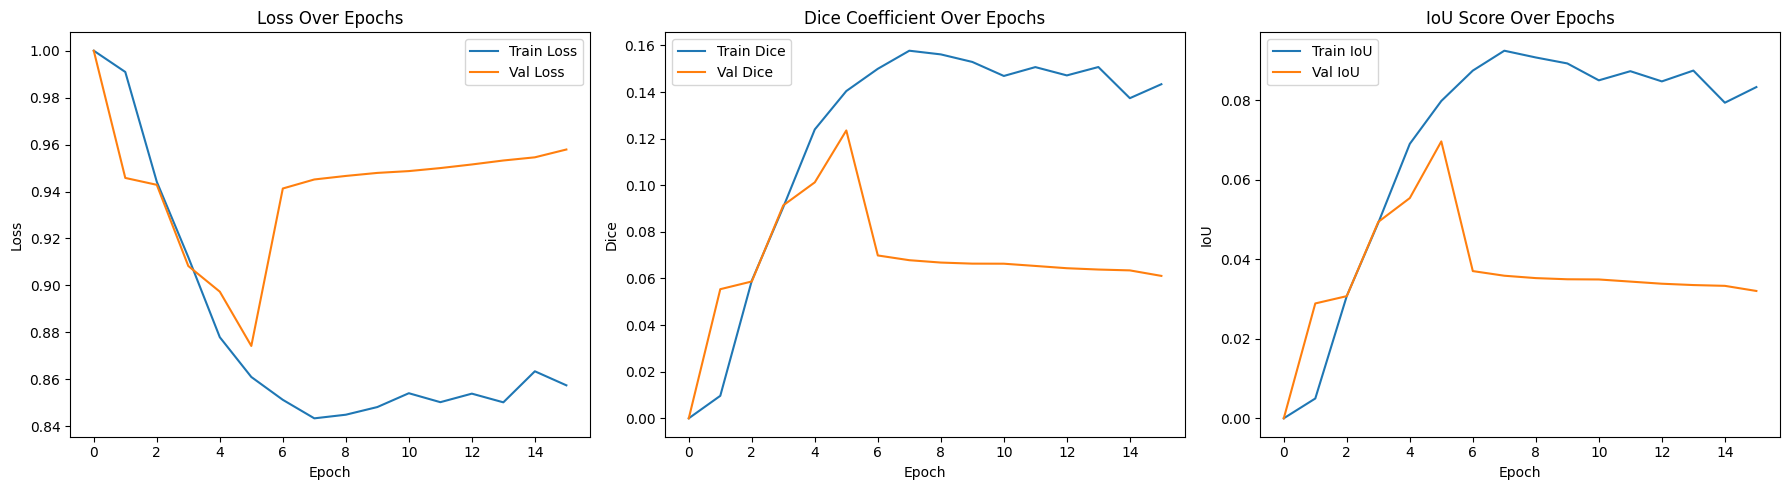

23176

In [ ]:
# Phase 3: Freeze conv00, conv10, conv20 conv30

import importlib.util
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import gc

# === Load UNet++ with Input Adapter from the specified path ===
unetpp_path = "/workspace/unetpp_input_adapter_ct.py"
spec = importlib.util.spec_from_file_location("UNetPP", unetpp_path)
unetpp_module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(unetpp_module)
UNetPlusPlus = unetpp_module.UNetPlusPlus

# === Prepare Data Paths ===
train_img_path = "/workspace/final_split_balanced/final_split_balanced/augmentedtrain/images"
train_mask_path = "/workspace/final_split_balanced/final_split_balanced/augmentedtrain/masks"
valid_img_path = "/workspace/final_split_balanced/final_split_balanced/valid/images"
valid_mask_path = "/workspace/final_split_balanced/final_split_balanced/valid/masks"

train_image_ids = sorted(os.listdir(train_img_path))
valid_image_ids = sorted(os.listdir(valid_img_path))

# === Model Training Parameters ===
img_size = 512
batch_size = 4
epochs = 50
lr = 1e-4

# === Compute Shape Prior & Visualize ===
shape_prior = compute_shape_prior_from_generator(train_gen)

plt.imshow(shape_prior[..., 0], cmap='hot')
plt.title("Shape Prior Heatmap")
plt.colorbar()
plt.show()

# === Define Data Generators ===
# Assumes DICOMDataGen is already defined somewhere accessible
train_gen = DICOMDataGen(train_image_ids, train_img_path, train_mask_path, batch_size, img_size, shuffle=True)
valid_gen = DICOMDataGen(valid_image_ids, valid_img_path, valid_mask_path, batch_size, img_size, shuffle=False)

# === Build Model ===
input_shape = (img_size, img_size, 1)
unetpp_instance = UNetPlusPlus(input_shape=input_shape)
model = unetpp_instance.BuildNetwork()

# === Load pretrained weights ===
weights_path = "/workspace/UNetpp_BrainTumorSegment.h5"
model.load_weights(weights_path, by_name=True, skip_mismatch=True)
print("Pretrained weights loaded.")

# === Freeze first three encoder layers (conv00, conv10, and conv20) ===
for layer in model.layers:
    if any(name in layer.name for name in ['conv00', 'conv10', 'conv20', 'conv30']):
        layer.trainable = False
    else:
        layer.trainable = True

# === Print frozen layers for confirmation ===
frozen_layers = [layer.name for layer in model.layers if not layer.trainable]
print("Frozen layers:", frozen_layers)
print("All other layers are set to trainable.")


# === Compile model ===
optimizer = tf.keras.optimizers.Adam(learning_rate=lr, clipnorm=0.5)
model.compile(
    optimizer=optimizer,
    loss=total_loss_fn(shape_prior),  # total_loss_fn and shape_prior should be defined
    metrics=[dice_coef, iou_score]    # dice_coef and iou_score should be defined
)

# === Train model ===
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_dice_coef', mode='max', patience=10, restore_best_weights=True, verbose=1)
]

history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1
)

# === Save model ===
os.makedirs("/workspace/input_adapter_layers", exist_ok=True)
model_path = "/workspace/input_adapter_layers/shapeprior_input_adapter_freeze_first_fourlayer.h5"
model.save(model_path)
print(f"Model saved to: {model_path}")

# === Plot Training Curves ===
history_dict = history.history
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(history_dict['loss'], label='Train Loss')
plt.plot(history_dict['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history_dict['dice_coef'], label='Train Dice')
plt.plot(history_dict['val_dice_coef'], label='Val Dice')
plt.title('Dice Coefficient Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Dice')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history_dict['iou_score'], label='Train IoU')
plt.plot(history_dict['val_iou_score'], label='Val IoU')
plt.title('IoU Score Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()

plt.tight_layout()
plt.show()


# === Cleanup ===
tf.keras.backend.clear_session()
gc.collect()



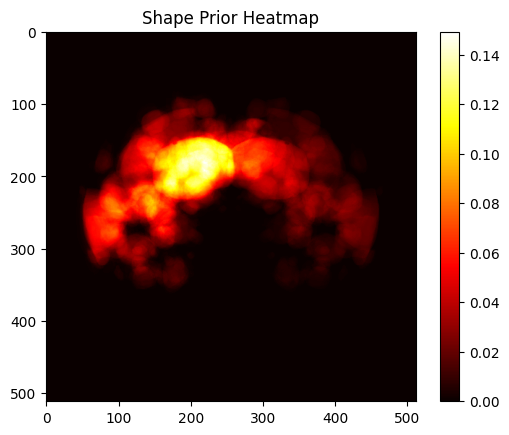

Pretrained weights loaded.
Frozen layers: ['conv00_1', 'conv00_2', 'conv10_1', 'conv10_2', 'conv20_1', 'conv20_2', 'conv30_1', 'conv30_2', 'conv40_1', 'conv40_2']
All other layers are set to trainable.
Epoch 1/50


2025-04-25 11:18:18.857852: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inUNetPP/X00_/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


454/454 [==============================] - 71s 142ms/step - loss: 0.9014 - dice_coef: 0.1033 - iou_score: 0.0557 - val_loss: 0.9019 - val_dice_coef: 0.1060 - val_iou_score: 0.0576
Epoch 2/50
454/454 [==============================] - 65s 142ms/step - loss: 0.8776 - dice_coef: 0.1264 - iou_score: 0.0697 - val_loss: 0.9122 - val_dice_coef: 0.0984 - val_iou_score: 0.0533
Epoch 3/50
454/454 [==============================] - 65s 143ms/step - loss: 0.8670 - dice_coef: 0.1368 - iou_score: 0.0757 - val_loss: 0.9030 - val_dice_coef: 0.1040 - val_iou_score: 0.0564
Epoch 4/50
454/454 [==============================] - 65s 144ms/step - loss: 0.8608 - dice_coef: 0.1429 - iou_score: 0.0796 - val_loss: 0.9063 - val_dice_coef: 0.1031 - val_iou_score: 0.0560
Epoch 5/50
454/454 [==============================] - 65s 144ms/step - loss: 0.8596 - dice_coef: 0.1441 - iou_score: 0.0804 - val_loss: 0.9114 - val_dice_coef: 0.0958 - val_iou_score: 0.0520
Epoch 6/50
454/454 [==============================] - 65

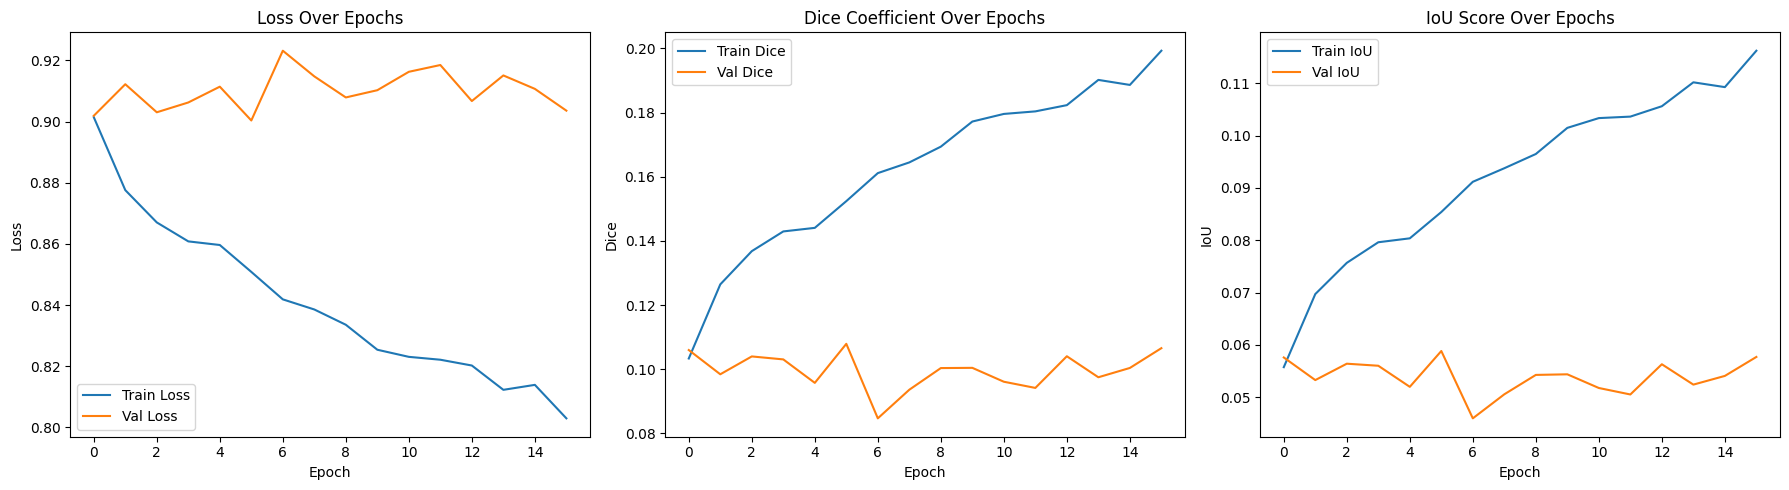

22810

In [ ]:
# Phase 3: Freeze conv00, conv10, conv20 conv30 and bottleneck

import importlib.util
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import gc

# === Load UNet++ with Input Adapter from the specified path ===
unetpp_path = "/workspace/unetpp_input_adapter_ct.py"
spec = importlib.util.spec_from_file_location("UNetPP", unetpp_path)
unetpp_module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(unetpp_module)
UNetPlusPlus = unetpp_module.UNetPlusPlus

# === Prepare Data Paths ===
train_img_path = "/workspace/final_split_balanced/final_split_balanced/augmentedtrain/images"
train_mask_path = "/workspace/final_split_balanced/final_split_balanced/augmentedtrain/masks"
valid_img_path = "/workspace/final_split_balanced/final_split_balanced/valid/images"
valid_mask_path = "/workspace/final_split_balanced/final_split_balanced/valid/masks"

train_image_ids = sorted(os.listdir(train_img_path))
valid_image_ids = sorted(os.listdir(valid_img_path))

# === Model Training Parameters ===
img_size = 512
batch_size = 4
epochs = 50
lr = 1e-4

# === Compute Shape Prior & Visualize ===
shape_prior = compute_shape_prior_from_generator(train_gen)

plt.imshow(shape_prior[..., 0], cmap='hot')
plt.title("Shape Prior Heatmap")
plt.colorbar()
plt.show()

# === Define Data Generators ===
# Assumes DICOMDataGen is already defined somewhere accessible
train_gen = DICOMDataGen(train_image_ids, train_img_path, train_mask_path, batch_size, img_size, shuffle=True)
valid_gen = DICOMDataGen(valid_image_ids, valid_img_path, valid_mask_path, batch_size, img_size, shuffle=False)

# === Build Model ===
input_shape = (img_size, img_size, 1)
unetpp_instance = UNetPlusPlus(input_shape=input_shape)
model = unetpp_instance.BuildNetwork()

# === Load pretrained weights ===
weights_path = "/workspace/UNetpp_BrainTumorSegment.h5"
model.load_weights(weights_path, by_name=True, skip_mismatch=True)
print("Pretrained weights loaded.")

# === Freeze first three encoder layers (conv00, conv10, and conv20) ===
for layer in model.layers:
    if any(name in layer.name for name in ['conv00', 'conv10', 'conv20', 'conv30','conv40']):
        layer.trainable = False
    else:
        layer.trainable = True

# === Print frozen layers for confirmation ===
frozen_layers = [layer.name for layer in model.layers if not layer.trainable]
print("Frozen layers:", frozen_layers)
print("All other layers are set to trainable.")


# === Compile model ===
optimizer = tf.keras.optimizers.Adam(learning_rate=lr, clipnorm=0.5)
model.compile(
    optimizer=optimizer,
    loss=total_loss_fn(shape_prior),  # total_loss_fn and shape_prior should be defined
    metrics=[dice_coef, iou_score]    # dice_coef and iou_score should be defined
)

# === Train model ===
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_dice_coef', mode='max', patience=10, restore_best_weights=True, verbose=1)
]

history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1
)

# === Save model ===
os.makedirs("/workspace/input_adapter_layers", exist_ok=True)
model_path = "/workspace/input_adapter_layers/shapeprior_input_adapter_freeze_first_fivelayer.h5"
model.save(model_path)
print(f"Model saved to: {model_path}")

# === Plot Training Curves ===
history_dict = history.history
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(history_dict['loss'], label='Train Loss')
plt.plot(history_dict['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history_dict['dice_coef'], label='Train Dice')
plt.plot(history_dict['val_dice_coef'], label='Val Dice')
plt.title('Dice Coefficient Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Dice')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history_dict['iou_score'], label='Train IoU')
plt.plot(history_dict['val_iou_score'], label='Val IoU')
plt.title('IoU Score Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()

plt.tight_layout()
plt.show()


# === Cleanup ===
tf.keras.backend.clear_session()
gc.collect()



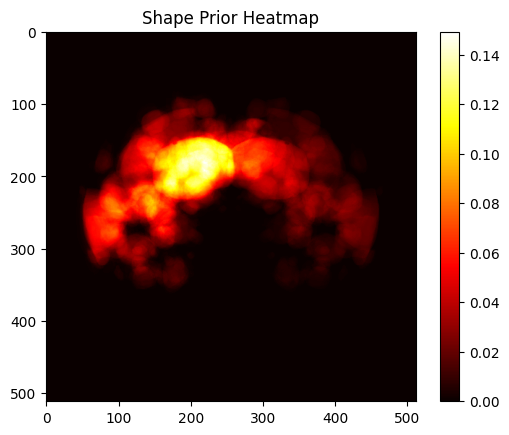

Pretrained weights loaded.
🧊 Frozen: conv00, conv10, conv20, conv30, conv40, conv01, conv11, conv21, conv31
 All other layers set to trainable
Epoch 1/50


2025-04-25 12:02:40.573617: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inUNetPP/X00_/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


454/454 [==============================] - 68s 138ms/step - loss: 0.9092 - dice_coef: 0.0957 - iou_score: 0.0514 - val_loss: 1.0001 - val_dice_coef: 7.9101e-06 - val_iou_score: 3.9554e-06
Epoch 2/50
454/454 [==============================] - 62s 137ms/step - loss: 0.8820 - dice_coef: 0.1223 - iou_score: 0.0669 - val_loss: 0.9301 - val_dice_coef: 0.0721 - val_iou_score: 0.0412
Epoch 3/50
454/454 [==============================] - 62s 137ms/step - loss: 0.8673 - dice_coef: 0.1368 - iou_score: 0.0757 - val_loss: 0.9117 - val_dice_coef: 0.0983 - val_iou_score: 0.0531
Epoch 4/50
454/454 [==============================] - 62s 137ms/step - loss: 0.8594 - dice_coef: 0.1446 - iou_score: 0.0804 - val_loss: 0.9107 - val_dice_coef: 0.0999 - val_iou_score: 0.0540
Epoch 5/50
454/454 [==============================] - 62s 137ms/step - loss: 0.8571 - dice_coef: 0.1467 - iou_score: 0.0818 - val_loss: 0.9050 - val_dice_coef: 0.1038 - val_iou_score: 0.0562
Epoch 6/50
454/454 [============================

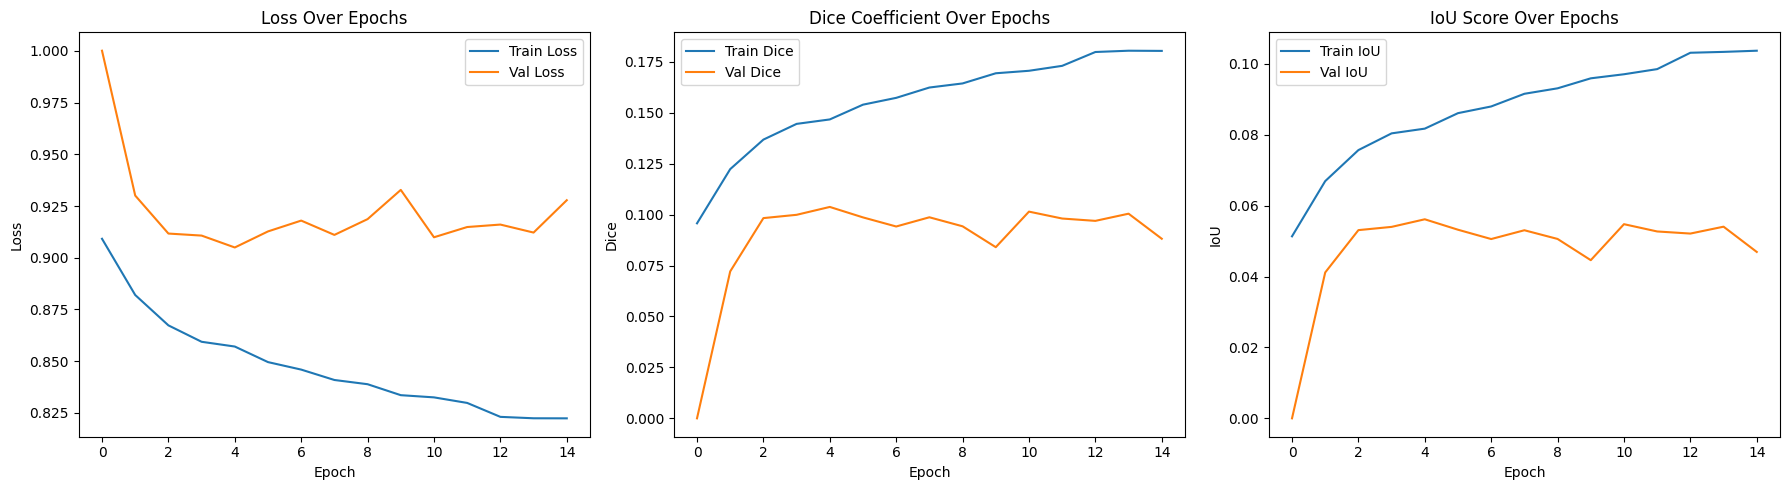

22918

In [ ]:
#Phase 6: Add shallow nested decoders conv01, conv11, conv21, conv31

import importlib.util
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import gc

# === Load UNet++ with Input Adapter from the specified path ===
unetpp_path = "/workspace/unetpp_input_adapter_ct.py"
spec = importlib.util.spec_from_file_location("UNetPP", unetpp_path)
unetpp_module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(unetpp_module)
UNetPlusPlus = unetpp_module.UNetPlusPlus

# === Prepare Data Paths ===
train_img_path = "/workspace/final_split_balanced/final_split_balanced/augmentedtrain/images"
train_mask_path = "/workspace/final_split_balanced/final_split_balanced/augmentedtrain/masks"
valid_img_path = "/workspace/final_split_balanced/final_split_balanced/valid/images"
valid_mask_path = "/workspace/final_split_balanced/final_split_balanced/valid/masks"

train_image_ids = sorted(os.listdir(train_img_path))
valid_image_ids = sorted(os.listdir(valid_img_path))

# === Model Training Parameters ===
img_size = 512
batch_size = 4
epochs = 50
lr = 1e-4

# === Compute Shape Prior & Visualize ===
shape_prior = compute_shape_prior_from_generator(train_gen)

plt.imshow(shape_prior[..., 0], cmap='hot')
plt.title("Shape Prior Heatmap")
plt.colorbar()
plt.show()

# === Define Data Generators ===
# Assumes DICOMDataGen is already defined somewhere accessible
train_gen = DICOMDataGen(train_image_ids, train_img_path, train_mask_path, batch_size, img_size, shuffle=True)
valid_gen = DICOMDataGen(valid_image_ids, valid_img_path, valid_mask_path, batch_size, img_size, shuffle=False)

# === Build Model ===
input_shape = (img_size, img_size, 1)
unetpp_instance = UNetPlusPlus(input_shape=input_shape)
model = unetpp_instance.BuildNetwork()

# === Load pretrained weights ===
weights_path = "/workspace/UNetpp_BrainTumorSegment.h5"
model.load_weights(weights_path, by_name=True, skip_mismatch=True)
print("Pretrained weights loaded.")

# === Freeze encoder + shallow nested decoder ===
freeze_list = ['conv00', 'conv10', 'conv20', 'conv30', 'conv40',
               'conv01', 'conv11', 'conv21', 'conv31']

for layer in model.layers:
    if any(name in layer.name for name in freeze_list):
        layer.trainable = False
    else:
        layer.trainable = True

print("🧊 Frozen:", ', '.join(freeze_list))




print(" All other layers set to trainable")

# === Compile model ===
optimizer = tf.keras.optimizers.Adam(learning_rate=lr, clipnorm=0.5)
model.compile(
    optimizer=optimizer,
    loss=total_loss_fn(shape_prior),  # total_loss_fn and shape_prior should be defined
    metrics=[dice_coef, iou_score]    # dice_coef and iou_score should be defined
)

# === Train model ===
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_dice_coef', mode='max', patience=10, restore_best_weights=True, verbose=1)
]

history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1
)

# === Save model ===
os.makedirs("/workspace/input_adapter_layers", exist_ok=True)
model_path = "/workspace/input_adapter_layers/shapeprior_input_adapter_freeze_encode_and_shaloowlayers.h5"
model.save(model_path)
print(f"Model saved to: {model_path}")

# === Plot Training Curves ===
history_dict = history.history
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(history_dict['loss'], label='Train Loss')
plt.plot(history_dict['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history_dict['dice_coef'], label='Train Dice')
plt.plot(history_dict['val_dice_coef'], label='Val Dice')
plt.title('Dice Coefficient Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Dice')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history_dict['iou_score'], label='Train IoU')
plt.plot(history_dict['val_iou_score'], label='Val IoU')
plt.title('IoU Score Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()

plt.tight_layout()
plt.show()


# === Cleanup ===
tf.keras.backend.clear_session()
gc.collect()



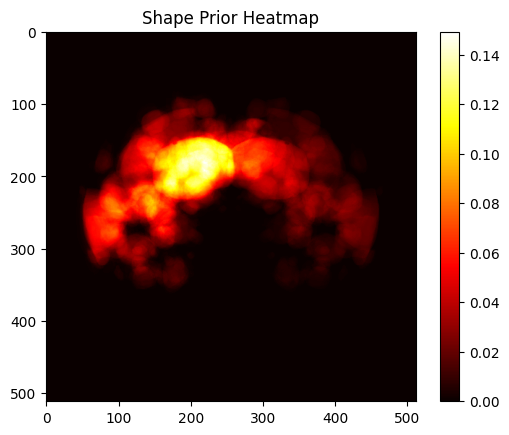

Pretrained weights loaded.
 Frozen: conv00, conv10, conv20, conv30, conv40, conv01, conv11, conv21, conv31, conv02, conv12, conv22
 All other layers set to trainable
Epoch 1/50


2025-04-25 13:00:54.008118: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inUNetPP/X00_/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


454/454 [==============================] - 79s 164ms/step - loss: 0.9217 - dice_coef: 0.0831 - iou_score: 0.0442 - val_loss: 0.9431 - val_dice_coef: 0.0597 - val_iou_score: 0.0325
Epoch 2/50
454/454 [==============================] - 59s 130ms/step - loss: 0.8914 - dice_coef: 0.1130 - iou_score: 0.0612 - val_loss: 0.9024 - val_dice_coef: 0.1045 - val_iou_score: 0.0567
Epoch 3/50
454/454 [==============================] - 65s 142ms/step - loss: 0.8809 - dice_coef: 0.1234 - iou_score: 0.0676 - val_loss: 0.9052 - val_dice_coef: 0.1023 - val_iou_score: 0.0555
Epoch 4/50
454/454 [==============================] - 60s 132ms/step - loss: 0.8719 - dice_coef: 0.1321 - iou_score: 0.0728 - val_loss: 0.9193 - val_dice_coef: 0.0862 - val_iou_score: 0.0476
Epoch 5/50
454/454 [==============================] - 58s 129ms/step - loss: 0.8639 - dice_coef: 0.1400 - iou_score: 0.0776 - val_loss: 0.9185 - val_dice_coef: 0.0882 - val_iou_score: 0.0484
Epoch 7/50
454/454 [==============================] - 59

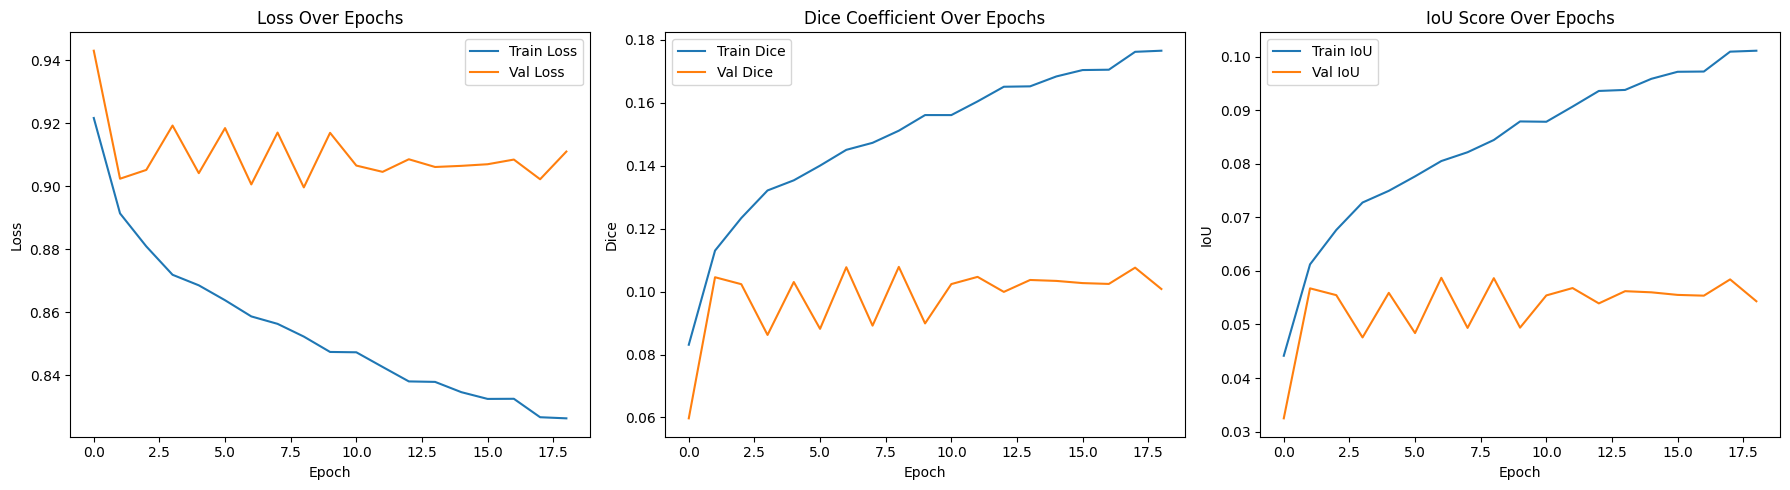

22433

In [ ]:
#Phase 6: Add more nested decoders ['conv00', 'conv10', 'conv20', 'conv30', 'conv40', 'conv01', 'conv11', 'conv21', 'conv31', 'conv02', 'conv12', 'conv22']

import importlib.util
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import gc

# === Load UNet++ with Input Adapter from the specified path ===
unetpp_path = "/workspace/unetpp_input_adapter_ct.py"
spec = importlib.util.spec_from_file_location("UNetPP", unetpp_path)
unetpp_module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(unetpp_module)
UNetPlusPlus = unetpp_module.UNetPlusPlus

# === Prepare Data Paths ===
train_img_path = "/workspace/final_split_balanced/final_split_balanced/augmentedtrain/images"
train_mask_path = "/workspace/final_split_balanced/final_split_balanced/augmentedtrain/masks"
valid_img_path = "/workspace/final_split_balanced/final_split_balanced/valid/images"
valid_mask_path = "/workspace/final_split_balanced/final_split_balanced/valid/masks"

train_image_ids = sorted(os.listdir(train_img_path))
valid_image_ids = sorted(os.listdir(valid_img_path))

# === Model Training Parameters ===
img_size = 512
batch_size = 4
epochs = 50
lr = 1e-4

# === Compute Shape Prior & Visualize ===
shape_prior = compute_shape_prior_from_generator(train_gen)

plt.imshow(shape_prior[..., 0], cmap='hot')
plt.title("Shape Prior Heatmap")
plt.colorbar()
plt.show()

# === Define Data Generators ===
# Assumes DICOMDataGen is already defined somewhere accessible
train_gen = DICOMDataGen(train_image_ids, train_img_path, train_mask_path, batch_size, img_size, shuffle=True)
valid_gen = DICOMDataGen(valid_image_ids, valid_img_path, valid_mask_path, batch_size, img_size, shuffle=False)

# === Build Model ===
input_shape = (img_size, img_size, 1)
unetpp_instance = UNetPlusPlus(input_shape=input_shape)
model = unetpp_instance.BuildNetwork()

# === Load pretrained weights ===
weights_path = "/workspace/UNetpp_BrainTumorSegment.h5"
model.load_weights(weights_path, by_name=True, skip_mismatch=True)
print("Pretrained weights loaded.")

# === Freeze encoder + more nested decoders ===
freeze_list = ['conv00', 'conv10', 'conv20', 'conv30', 'conv40',
               'conv01', 'conv11', 'conv21', 'conv31',
               'conv02', 'conv12', 'conv22']

for layer in model.layers:
    if any(name in layer.name for name in freeze_list):
        layer.trainable = False
    else:
        layer.trainable = True

print(" Frozen:", ', '.join(freeze_list))



print(" All other layers set to trainable")

# === Compile model ===
optimizer = tf.keras.optimizers.Adam(learning_rate=lr, clipnorm=0.5)
model.compile(
    optimizer=optimizer,
    loss=total_loss_fn(shape_prior),  # total_loss_fn and shape_prior should be defined
    metrics=[dice_coef, iou_score]    # dice_coef and iou_score should be defined
)

# === Train model ===
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_dice_coef', mode='max', patience=10, restore_best_weights=True, verbose=1)
]

history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1
)

# === Save model ===
os.makedirs("/workspace/input_adapter_layers", exist_ok=True)
model_path = "/workspace/input_adapter_layers/shapeprior_input_adapter_freeze_encode_and_shaloow_morelayers.h5"
model.save(model_path)
print(f"Model saved to: {model_path}")

# === Plot Training Curves ===
history_dict = history.history
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(history_dict['loss'], label='Train Loss')
plt.plot(history_dict['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history_dict['dice_coef'], label='Train Dice')
plt.plot(history_dict['val_dice_coef'], label='Val Dice')
plt.title('Dice Coefficient Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Dice')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history_dict['iou_score'], label='Train IoU')
plt.plot(history_dict['val_iou_score'], label='Val IoU')
plt.title('IoU Score Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()

plt.tight_layout()
plt.show()


# === Cleanup ===
tf.keras.backend.clear_session()
gc.collect()



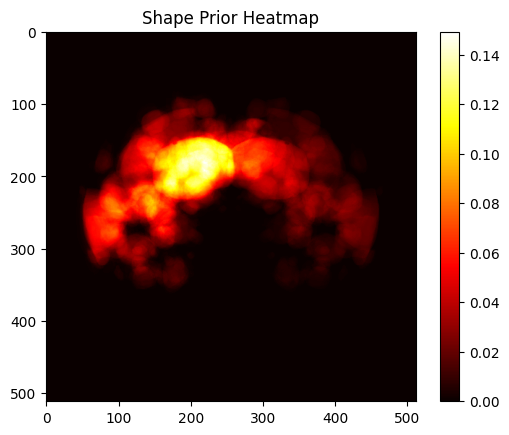

Pretrained weights loaded.
 Frozen: conv00, conv10, conv20, conv30, conv40, conv01, conv11, conv21, conv31, conv02, conv12, conv22, conv03, conv13
 All other layers set to trainable
Epoch 1/50


2025-04-25 13:22:47.493602: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inUNetPP/X00_/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


454/454 [==============================] - 60s 124ms/step - loss: 0.9270 - dice_coef: 0.0777 - iou_score: 0.0413 - val_loss: 0.9220 - val_dice_coef: 0.0882 - val_iou_score: 0.0471
Epoch 2/50
454/454 [==============================] - 56s 123ms/step - loss: 0.8907 - dice_coef: 0.1138 - iou_score: 0.0619 - val_loss: 0.9131 - val_dice_coef: 0.0978 - val_iou_score: 0.0526
Epoch 3/50
454/454 [==============================] - 56s 123ms/step - loss: 0.8801 - dice_coef: 0.1243 - iou_score: 0.0680 - val_loss: 0.9103 - val_dice_coef: 0.0993 - val_iou_score: 0.0537
Epoch 4/50
454/454 [==============================] - 56s 123ms/step - loss: 0.8742 - dice_coef: 0.1302 - iou_score: 0.0718 - val_loss: 0.9098 - val_dice_coef: 0.1001 - val_iou_score: 0.0542
Epoch 5/50
454/454 [==============================] - 56s 123ms/step - loss: 0.8675 - dice_coef: 0.1366 - iou_score: 0.0758 - val_loss: 0.9058 - val_dice_coef: 0.1029 - val_iou_score: 0.0559
Epoch 6/50
454/454 [==============================] - 56

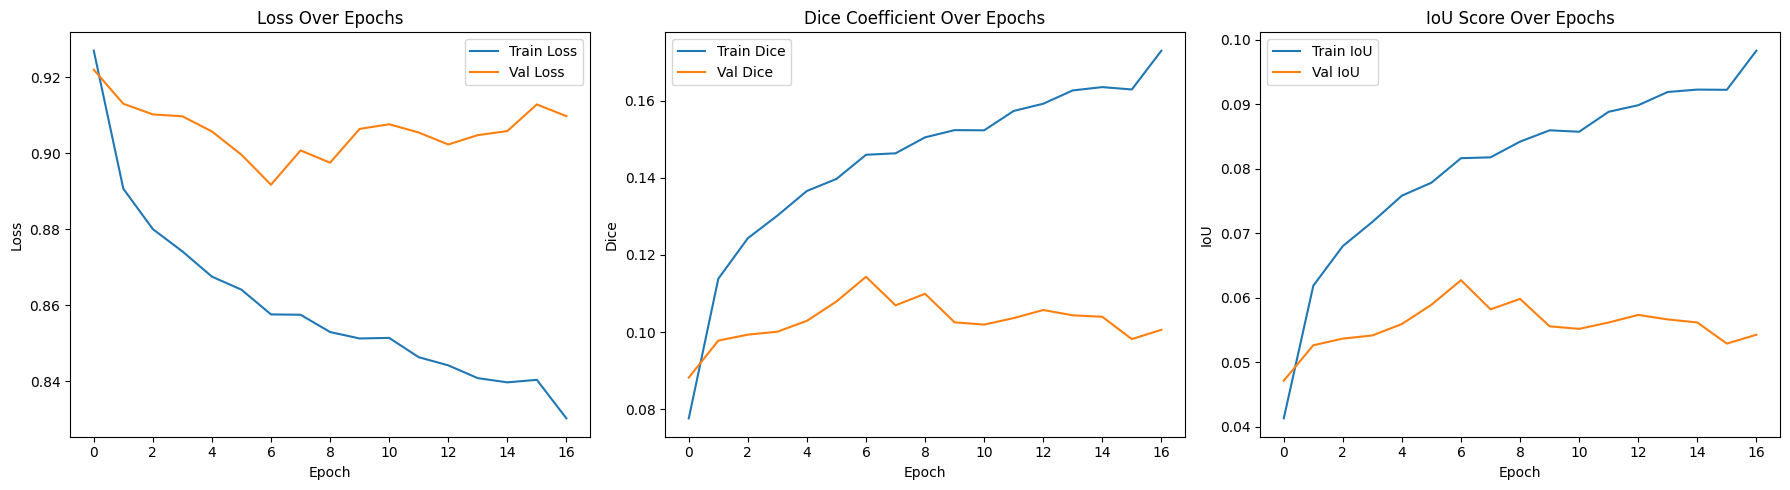

22520

In [ ]:
#Phase 6: Add more nested decoders ['conv00', 'conv10', 'conv20', 'conv30', 'conv40', 'conv01', 'conv11', 'conv21', 'conv31', 'conv02', 'conv12', 'conv22']'conv03', 'conv13']

import importlib.util
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import gc

# === Load UNet++ with Input Adapter from the specified path ===
unetpp_path = "/workspace/unetpp_input_adapter_ct.py"
spec = importlib.util.spec_from_file_location("UNetPP", unetpp_path)
unetpp_module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(unetpp_module)
UNetPlusPlus = unetpp_module.UNetPlusPlus

# === Prepare Data Paths ===
train_img_path = "/workspace/final_split_balanced/final_split_balanced/augmentedtrain/images"
train_mask_path = "/workspace/final_split_balanced/final_split_balanced/augmentedtrain/masks"
valid_img_path = "/workspace/final_split_balanced/final_split_balanced/valid/images"
valid_mask_path = "/workspace/final_split_balanced/final_split_balanced/valid/masks"

train_image_ids = sorted(os.listdir(train_img_path))
valid_image_ids = sorted(os.listdir(valid_img_path))

# === Model Training Parameters ===
img_size = 512
batch_size = 4
epochs = 50
lr = 1e-4

# === Compute Shape Prior & Visualize ===
shape_prior = compute_shape_prior_from_generator(train_gen)

plt.imshow(shape_prior[..., 0], cmap='hot')
plt.title("Shape Prior Heatmap")
plt.colorbar()
plt.show()

# === Define Data Generators ===
# Assumes DICOMDataGen is already defined somewhere accessible
train_gen = DICOMDataGen(train_image_ids, train_img_path, train_mask_path, batch_size, img_size, shuffle=True)
valid_gen = DICOMDataGen(valid_image_ids, valid_img_path, valid_mask_path, batch_size, img_size, shuffle=False)

# === Build Model ===
input_shape = (img_size, img_size, 1)
unetpp_instance = UNetPlusPlus(input_shape=input_shape)
model = unetpp_instance.BuildNetwork()

# === Load pretrained weights ===
weights_path = "/workspace/UNetpp_BrainTumorSegment.h5"
model.load_weights(weights_path, by_name=True, skip_mismatch=True)
print("Pretrained weights loaded.")

# === Freeze encoder + deeper nested decoders ===
freeze_list = ['conv00', 'conv10', 'conv20', 'conv30', 'conv40',
               'conv01', 'conv11', 'conv21', 'conv31',
               'conv02', 'conv12', 'conv22',
               'conv03', 'conv13']
for layer in model.layers:
    if any(name in layer.name for name in freeze_list):
        layer.trainable = False
    else:
        layer.trainable = True

print(" Frozen:", ', '.join(freeze_list))



print(" All other layers set to trainable")

# === Compile model ===
optimizer = tf.keras.optimizers.Adam(learning_rate=lr, clipnorm=0.5)
model.compile(
    optimizer=optimizer,
    loss=total_loss_fn(shape_prior),  # total_loss_fn and shape_prior should be defined
    metrics=[dice_coef, iou_score]    # dice_coef and iou_score should be defined
)

# === Train model ===
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_dice_coef', mode='max', patience=10, restore_best_weights=True, verbose=1)
]

history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1
)

# === Save model ===
os.makedirs("/workspace/input_adapter_layers", exist_ok=True)
model_path = "/workspace/input_adapter_layers/shapeprior_input_adapter_freeze_encode_and_shaloow_deeperlayers.h5"
model.save(model_path)
print(f"Model saved to: {model_path}")

# === Plot Training Curves ===
history_dict = history.history
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(history_dict['loss'], label='Train Loss')
plt.plot(history_dict['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history_dict['dice_coef'], label='Train Dice')
plt.plot(history_dict['val_dice_coef'], label='Val Dice')
plt.title('Dice Coefficient Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Dice')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history_dict['iou_score'], label='Train IoU')
plt.plot(history_dict['val_iou_score'], label='Val IoU')
plt.title('IoU Score Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()

plt.tight_layout()
plt.show()


# === Cleanup ===
tf.keras.backend.clear_session()
gc.collect()



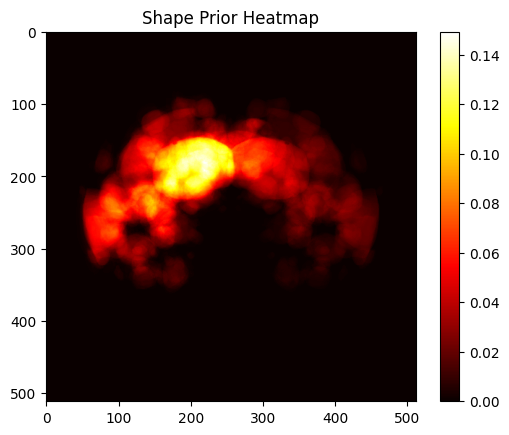

Pretrained weights loaded.
 All other layers set to trainable
 All other layers set to trainable
Epoch 1/50


2025-04-25 13:42:57.819460: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inUNetPP/X00_/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


454/454 [==============================] - 76s 147ms/step - loss: 0.8437 - dice_coef: 0.1591 - iou_score: 0.0906 - val_loss: 1.0001 - val_dice_coef: 2.3162e-10 - val_iou_score: 2.3162e-10
Epoch 2/50
454/454 [==============================] - 67s 148ms/step - loss: 0.7666 - dice_coef: 0.2349 - iou_score: 0.1423 - val_loss: 0.8988 - val_dice_coef: 0.1065 - val_iou_score: 0.0579
Epoch 3/50
454/454 [==============================] - 67s 148ms/step - loss: 0.7170 - dice_coef: 0.2842 - iou_score: 0.1803 - val_loss: 0.8824 - val_dice_coef: 0.1230 - val_iou_score: 0.0675
Epoch 4/50
454/454 [==============================] - 67s 148ms/step - loss: 0.6554 - dice_coef: 0.3455 - iou_score: 0.2290 - val_loss: 0.8965 - val_dice_coef: 0.1126 - val_iou_score: 0.0609
Epoch 5/50
454/454 [==============================] - 67s 148ms/step - loss: 0.6148 - dice_coef: 0.3860 - iou_score: 0.2648 - val_loss: 0.9548 - val_dice_coef: 0.0665 - val_iou_score: 0.0348
Epoch 6/50
454/454 [============================

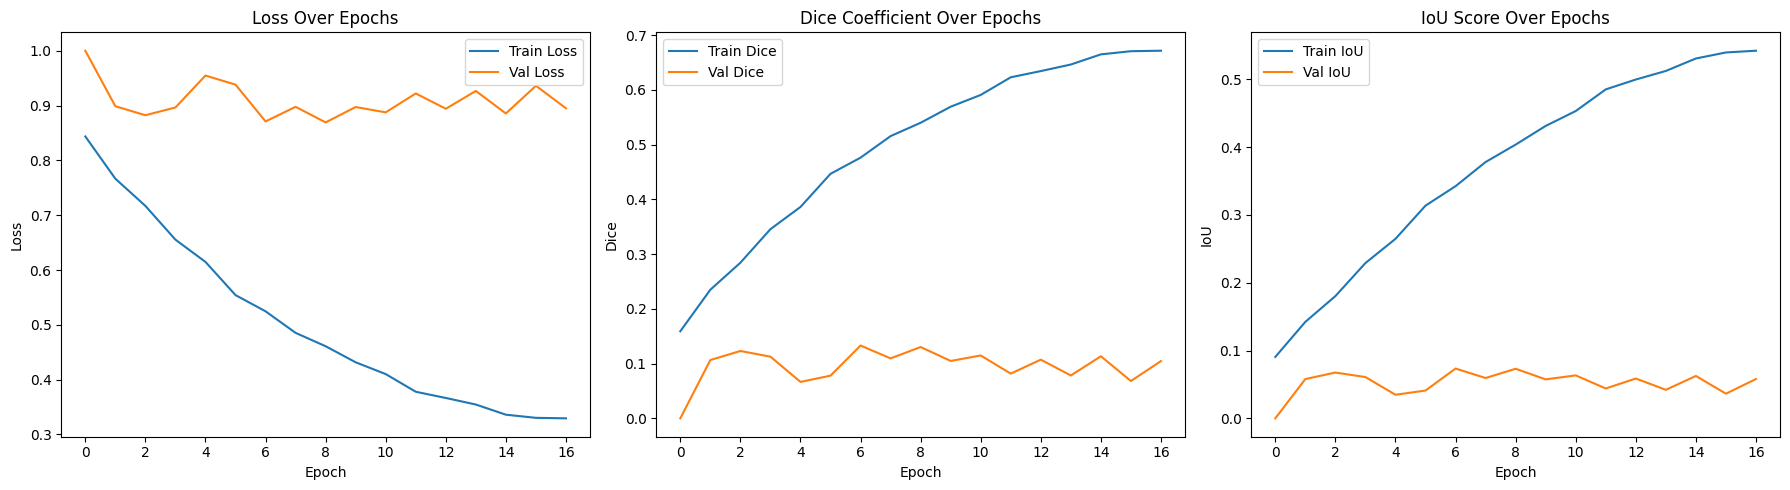

22633

In [ ]:
#Phase 6: unfreeze all layers
import importlib.util
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import gc

# === Load UNet++ with Input Adapter from the specified path ===
unetpp_path = "/workspace/unetpp_input_adapter_ct.py"
spec = importlib.util.spec_from_file_location("UNetPP", unetpp_path)
unetpp_module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(unetpp_module)
UNetPlusPlus = unetpp_module.UNetPlusPlus

# === Prepare Data Paths ===
train_img_path = "/workspace/final_split_balanced/final_split_balanced/augmentedtrain/images"
train_mask_path = "/workspace/final_split_balanced/final_split_balanced/augmentedtrain/masks"
valid_img_path = "/workspace/final_split_balanced/final_split_balanced/valid/images"
valid_mask_path = "/workspace/final_split_balanced/final_split_balanced/valid/masks"

train_image_ids = sorted(os.listdir(train_img_path))
valid_image_ids = sorted(os.listdir(valid_img_path))

# === Model Training Parameters ===
img_size = 512
batch_size = 4
epochs = 50
lr = 1e-4

# === Compute Shape Prior & Visualize ===
shape_prior = compute_shape_prior_from_generator(train_gen)

plt.imshow(shape_prior[..., 0], cmap='hot')
plt.title("Shape Prior Heatmap")
plt.colorbar()
plt.show()

# === Define Data Generators ===
# Assumes DICOMDataGen is already defined somewhere accessible
train_gen = DICOMDataGen(train_image_ids, train_img_path, train_mask_path, batch_size, img_size, shuffle=True)
valid_gen = DICOMDataGen(valid_image_ids, valid_img_path, valid_mask_path, batch_size, img_size, shuffle=False)

# === Build Model ===
input_shape = (img_size, img_size, 1)
unetpp_instance = UNetPlusPlus(input_shape=input_shape)
model = unetpp_instance.BuildNetwork()

# === Load pretrained weights ===
weights_path = "/workspace/UNetpp_BrainTumorSegment.h5"
model.load_weights(weights_path, by_name=True, skip_mismatch=True)
print("Pretrained weights loaded.")


for layer in model.layers:
    layer.trainable = True





print(" All other layers set to trainable")


print(" All other layers set to trainable")

# === Compile model ===
optimizer = tf.keras.optimizers.Adam(learning_rate=lr, clipnorm=0.5)
model.compile(
    optimizer=optimizer,
    loss=total_loss_fn(shape_prior),  # total_loss_fn and shape_prior should be defined
    metrics=[dice_coef, iou_score]    # dice_coef and iou_score should be defined
)

# === Train model ===
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_dice_coef', mode='max', patience=10, restore_best_weights=True, verbose=1)
]

history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1
)

# === Save model ===
os.makedirs("/workspace/input_adapter_layers", exist_ok=True)
model_path = "/workspace/input_adapter_layers/shapeprior_input_adapter_freeze_encode_and_shaloow_deeperlayers.h5"
model.save(model_path)
print(f"Model saved to: {model_path}")

# === Plot Training Curves ===
history_dict = history.history
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(history_dict['loss'], label='Train Loss')
plt.plot(history_dict['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history_dict['dice_coef'], label='Train Dice')
plt.plot(history_dict['val_dice_coef'], label='Val Dice')
plt.title('Dice Coefficient Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Dice')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history_dict['iou_score'], label='Train IoU')
plt.plot(history_dict['val_iou_score'], label='Val IoU')
plt.title('IoU Score Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()

plt.tight_layout()
plt.show()


# === Cleanup ===
tf.keras.backend.clear_session()
gc.collect()



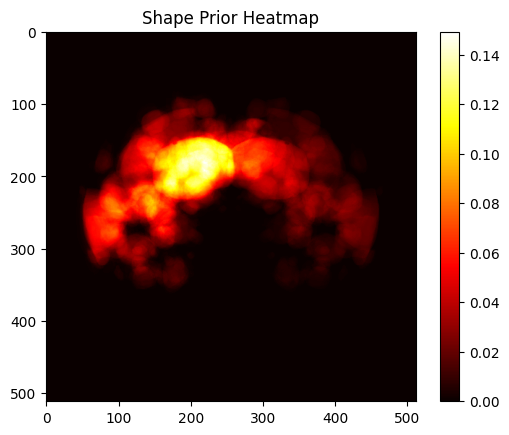

Pretrained weights loaded.
Freezing layer: conv00_1
Freezing layer: conv00_2
Freezing layer: conv10_1
Freezing layer: conv10_2
Freezing layer: conv01_1
Freezing layer: conv01_2
 All other layers set to trainable
Epoch 1/50


2025-04-25 14:05:25.665842: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inUNetPP/X00_/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


454/454 [==============================] - 72s 142ms/step - loss: 0.8714 - dice_coef: 0.1319 - iou_score: 0.0732 - val_loss: 0.8757 - val_dice_coef: 0.1267 - val_iou_score: 0.0710
Epoch 2/50
454/454 [==============================] - 64s 141ms/step - loss: 0.8142 - dice_coef: 0.1879 - iou_score: 0.1098 - val_loss: 0.9509 - val_dice_coef: 0.0475 - val_iou_score: 0.0256
Epoch 3/50
454/454 [==============================] - 64s 141ms/step - loss: 0.7726 - dice_coef: 0.2286 - iou_score: 0.1399 - val_loss: 0.8224 - val_dice_coef: 0.1779 - val_iou_score: 0.1012
Epoch 4/50
454/454 [==============================] - 64s 141ms/step - loss: 0.7383 - dice_coef: 0.2628 - iou_score: 0.1656 - val_loss: 0.8994 - val_dice_coef: 0.1097 - val_iou_score: 0.0595
Epoch 5/50
454/454 [==============================] - 64s 141ms/step - loss: 0.7128 - dice_coef: 0.2882 - iou_score: 0.1848 - val_loss: 0.8848 - val_dice_coef: 0.1216 - val_iou_score: 0.0666
Epoch 6/50
454/454 [==============================] - 64

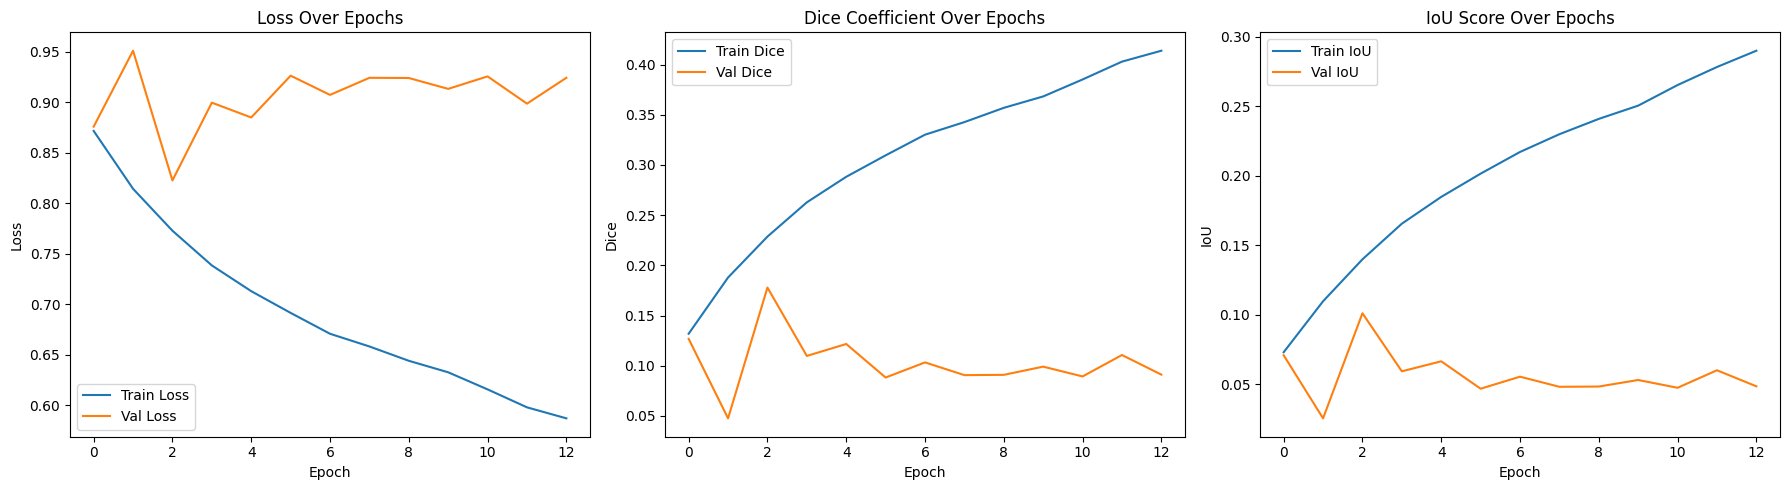

22944

In [ ]:
#initial Dense encoder path
import importlib.util
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import gc

# === Load UNet++ with Input Adapter from the specified path ===
unetpp_path = "/workspace/unetpp_input_adapter_ct.py"
spec = importlib.util.spec_from_file_location("UNetPP", unetpp_path)
unetpp_module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(unetpp_module)
UNetPlusPlus = unetpp_module.UNetPlusPlus

# === Prepare Data Paths ===
train_img_path = "/workspace/final_split_balanced/final_split_balanced/augmentedtrain/images"
train_mask_path = "/workspace/final_split_balanced/final_split_balanced/augmentedtrain/masks"
valid_img_path = "/workspace/final_split_balanced/final_split_balanced/valid/images"
valid_mask_path = "/workspace/final_split_balanced/final_split_balanced/valid/masks"

train_image_ids = sorted(os.listdir(train_img_path))
valid_image_ids = sorted(os.listdir(valid_img_path))

# === Model Training Parameters ===
img_size = 512
batch_size = 4
epochs = 50
lr = 1e-4

# === Compute Shape Prior & Visualize ===
shape_prior = compute_shape_prior_from_generator(train_gen)

plt.imshow(shape_prior[..., 0], cmap='hot')
plt.title("Shape Prior Heatmap")
plt.colorbar()
plt.show()

# === Define Data Generators ===
# Assumes DICOMDataGen is already defined somewhere accessible
train_gen = DICOMDataGen(train_image_ids, train_img_path, train_mask_path, batch_size, img_size, shuffle=True)
valid_gen = DICOMDataGen(valid_image_ids, valid_img_path, valid_mask_path, batch_size, img_size, shuffle=False)

# === Build Model ===
input_shape = (img_size, img_size, 1)
unetpp_instance = UNetPlusPlus(input_shape=input_shape)
model = unetpp_instance.BuildNetwork()

# === Load pretrained weights ===
weights_path = "/workspace/UNetpp_BrainTumorSegment.h5"
model.load_weights(weights_path, by_name=True, skip_mismatch=True)
print("Pretrained weights loaded.")



# Freeze initial dense encoder path layers
for layer in model.layers:
    if any(name in layer.name for name in ['conv00', 'conv10', 'conv01']):
        layer.trainable = False
        print(f"Freezing layer: {layer.name}")
    # others
    for layer in model.layers:
        if layer.trainable is not False:
            layer.trainable = True


print(" All other layers set to trainable")


# === Compile model ===
optimizer = tf.keras.optimizers.Adam(learning_rate=lr, clipnorm=0.5)
model.compile(
    optimizer=optimizer,
    loss=total_loss_fn(shape_prior),  # total_loss_fn and shape_prior should be defined
    metrics=[dice_coef, iou_score]    # dice_coef and iou_score should be defined
)

# === Train model ===
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_dice_coef', mode='max', patience=10, restore_best_weights=True, verbose=1)
]

history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1
)

# === Save model ===
os.makedirs("/workspace/input_adapter_layers", exist_ok=True)
model_path = "/workspace/input_adapter_layers/shapeprior_input_adapter_freeze_initial_denselayers.h5"
model.save(model_path)
print(f"Model saved to: {model_path}")

# === Plot Training Curves ===
history_dict = history.history
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(history_dict['loss'], label='Train Loss')
plt.plot(history_dict['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history_dict['dice_coef'], label='Train Dice')
plt.plot(history_dict['val_dice_coef'], label='Val Dice')
plt.title('Dice Coefficient Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Dice')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history_dict['iou_score'], label='Train IoU')
plt.plot(history_dict['val_iou_score'], label='Val IoU')
plt.title('IoU Score Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()

plt.tight_layout()
plt.show()


# === Cleanup ===
tf.keras.backend.clear_session()
gc.collect()



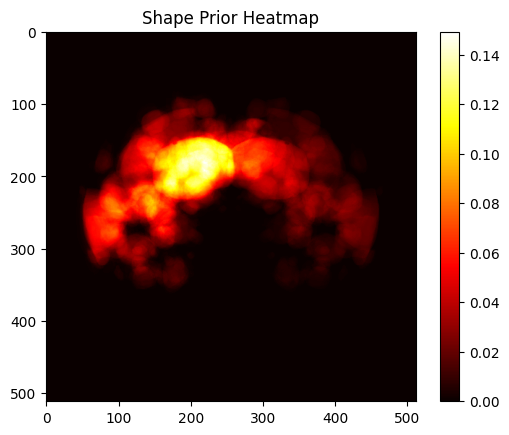

Pretrained weights loaded.
Freezing layer: conv00_1
Freezing layer: conv00_2
Freezing layer: conv10_1
Freezing layer: conv10_2
Freezing layer: conv20_1
Freezing layer: conv20_2
Freezing layer: conv11_1
Freezing layer: conv01_1
Freezing layer: conv11_2
Freezing layer: conv01_2
Freezing layer: conv02_1
Freezing layer: conv02_2
 All other layers set to trainable
Epoch 1/50


2025-04-25 14:25:25.886339: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inUNetPP/X00_/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


454/454 [==============================] - 68s 136ms/step - loss: 0.8786 - dice_coef: 0.1249 - iou_score: 0.0691 - val_loss: 0.8533 - val_dice_coef: 0.1485 - val_iou_score: 0.0825
Epoch 2/50
454/454 [==============================] - 62s 136ms/step - loss: 0.8319 - dice_coef: 0.1701 - iou_score: 0.0986 - val_loss: 0.8632 - val_dice_coef: 0.1389 - val_iou_score: 0.0780
Epoch 3/50
454/454 [==============================] - 62s 137ms/step - loss: 0.7954 - dice_coef: 0.2059 - iou_score: 0.1239 - val_loss: 0.8652 - val_dice_coef: 0.1385 - val_iou_score: 0.0768
Epoch 4/50
454/454 [==============================] - 62s 136ms/step - loss: 0.7663 - dice_coef: 0.2348 - iou_score: 0.1447 - val_loss: 0.8764 - val_dice_coef: 0.1293 - val_iou_score: 0.0712
Epoch 5/50
454/454 [==============================] - 62s 136ms/step - loss: 0.7524 - dice_coef: 0.2486 - iou_score: 0.1557 - val_loss: 0.8900 - val_dice_coef: 0.1186 - val_iou_score: 0.0647
Epoch 6/50
454/454 [==============================] - 62

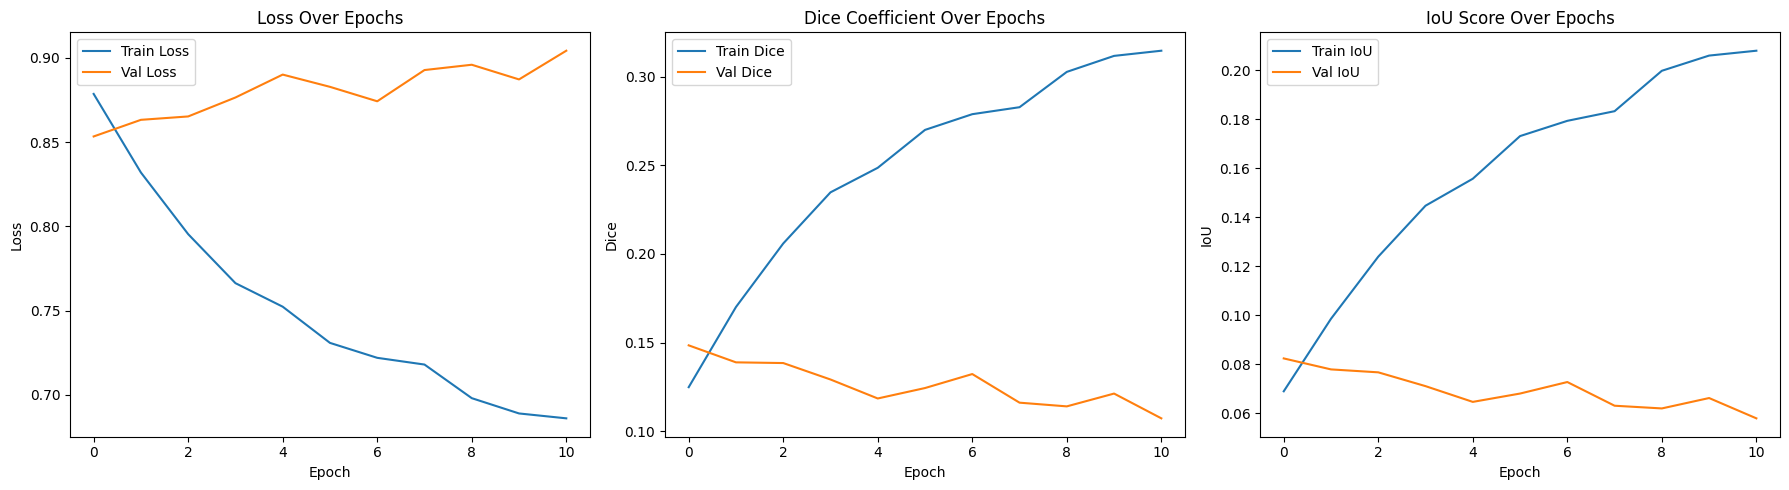

22084

In [ ]:
#initial_second Dense encoder path
import importlib.util
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import gc

# === Load UNet++ with Input Adapter from the specified path ===
unetpp_path = "/workspace/unetpp_input_adapter_ct.py"
spec = importlib.util.spec_from_file_location("UNetPP", unetpp_path)
unetpp_module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(unetpp_module)
UNetPlusPlus = unetpp_module.UNetPlusPlus

# === Prepare Data Paths ===
train_img_path = "/workspace/final_split_balanced/final_split_balanced/augmentedtrain/images"
train_mask_path = "/workspace/final_split_balanced/final_split_balanced/augmentedtrain/masks"
valid_img_path = "/workspace/final_split_balanced/final_split_balanced/valid/images"
valid_mask_path = "/workspace/final_split_balanced/final_split_balanced/valid/masks"

train_image_ids = sorted(os.listdir(train_img_path))
valid_image_ids = sorted(os.listdir(valid_img_path))

# === Model Training Parameters ===
img_size = 512
batch_size = 4
epochs = 50
lr = 1e-4

# === Compute Shape Prior & Visualize ===
shape_prior = compute_shape_prior_from_generator(train_gen)

plt.imshow(shape_prior[..., 0], cmap='hot')
plt.title("Shape Prior Heatmap")
plt.colorbar()
plt.show()

# === Define Data Generators ===
# Assumes DICOMDataGen is already defined somewhere accessible
train_gen = DICOMDataGen(train_image_ids, train_img_path, train_mask_path, batch_size, img_size, shuffle=True)
valid_gen = DICOMDataGen(valid_image_ids, valid_img_path, valid_mask_path, batch_size, img_size, shuffle=False)

# === Build Model ===
input_shape = (img_size, img_size, 1)
unetpp_instance = UNetPlusPlus(input_shape=input_shape)
model = unetpp_instance.BuildNetwork()

# === Load pretrained weights ===
weights_path = "/workspace/UNetpp_BrainTumorSegment.h5"
model.load_weights(weights_path, by_name=True, skip_mismatch=True)
print("Pretrained weights loaded.")



# Freeze selected encoder and early decoder layers in UNet++
freeze_targets = ['conv00', 'conv10', 'conv20', 'conv01', 'conv02', 'conv11']

for layer in model.layers:
    if any(name in layer.name for name in freeze_targets):
        layer.trainable = False
        print(f"Freezing layer: {layer.name}")


print(" All other layers set to trainable")


# === Compile model ===
optimizer = tf.keras.optimizers.Adam(learning_rate=lr, clipnorm=0.5)
model.compile(
    optimizer=optimizer,
    loss=total_loss_fn(shape_prior),  # total_loss_fn and shape_prior should be defined
    metrics=[dice_coef, iou_score]    # dice_coef and iou_score should be defined
)

# === Train model ===
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_dice_coef', mode='max', patience=10, restore_best_weights=True, verbose=1)
]

history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1
)

# === Save model ===
os.makedirs("/workspace/input_adapter_layers", exist_ok=True)
model_path = "/workspace/input_adapter_layers/shapeprior_input_adapter_freeze_initial_seconddenselayers.h5"
model.save(model_path)
print(f"Model saved to: {model_path}")

# === Plot Training Curves ===
history_dict = history.history
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(history_dict['loss'], label='Train Loss')
plt.plot(history_dict['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history_dict['dice_coef'], label='Train Dice')
plt.plot(history_dict['val_dice_coef'], label='Val Dice')
plt.title('Dice Coefficient Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Dice')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history_dict['iou_score'], label='Train IoU')
plt.plot(history_dict['val_iou_score'], label='Val IoU')
plt.title('IoU Score Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()

plt.tight_layout()
plt.show()


# === Cleanup ===
tf.keras.backend.clear_session()
gc.collect()



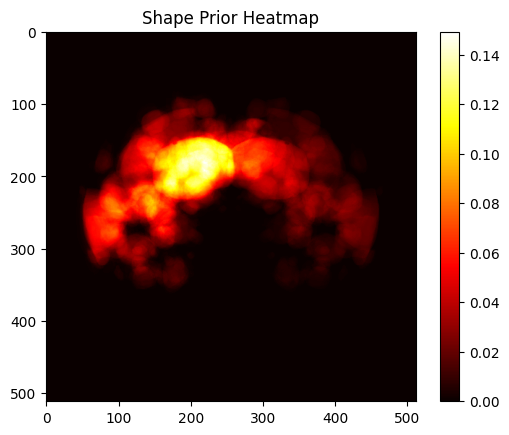

Pretrained weights loaded.
Freezing layer: conv00_1
Freezing layer: conv00_2
Freezing layer: conv10_1
Freezing layer: conv10_2
Freezing layer: conv20_1
Freezing layer: conv20_2
Freezing layer: conv30_1
Freezing layer: conv30_2
Freezing layer: conv21_1
Freezing layer: conv11_1
Freezing layer: conv21_2
Freezing layer: conv01_1
Freezing layer: conv11_2
Freezing layer: conv01_2
Freezing layer: conv12_1
Freezing layer: conv02_1
Freezing layer: conv12_2
Freezing layer: conv02_2
Freezing layer: conv03_1
Freezing layer: conv03_2
 All other layers set to trainable
Epoch 1/50


2025-04-25 15:00:09.773438: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inUNetPP/X00_/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


454/454 [==============================] - 63s 128ms/step - loss: 1.0001 - dice_coef: 2.7713e-05 - iou_score: 1.3858e-05 - val_loss: 1.0001 - val_dice_coef: 2.3142e-10 - val_iou_score: 2.3142e-10
Epoch 2/50
454/454 [==============================] - 58s 128ms/step - loss: 1.0000 - dice_coef: 3.3409e-05 - iou_score: 1.6706e-05 - val_loss: 1.0001 - val_dice_coef: 2.3082e-10 - val_iou_score: 2.3082e-10
Epoch 3/50
454/454 [==============================] - 58s 128ms/step - loss: 1.0000 - dice_coef: 3.0846e-05 - iou_score: 1.5424e-05 - val_loss: 1.0001 - val_dice_coef: 2.3008e-10 - val_iou_score: 2.3008e-10
Epoch 4/50
454/454 [==============================] - 58s 128ms/step - loss: 1.0000 - dice_coef: 5.0730e-05 - iou_score: 2.5368e-05 - val_loss: 1.0001 - val_dice_coef: 2.3000e-10 - val_iou_score: 2.3000e-10
Epoch 5/50
454/454 [==============================] - 58s 129ms/step - loss: 0.9786 - dice_coef: 0.0227 - iou_score: 0.0118 - val_loss: 0.9433 - val_dice_coef: 0.0588 - val_iou_score:

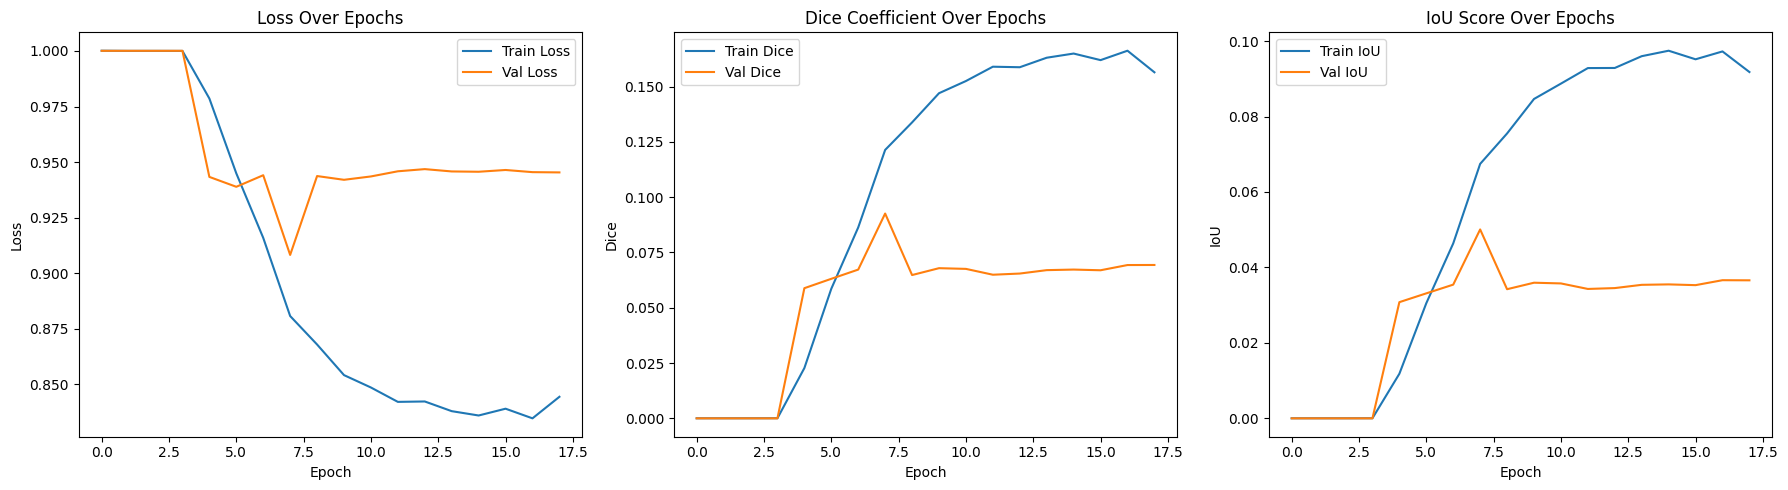

22370

In [ ]:
#initial_second_third Dense encoder path
import importlib.util
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import gc

# === Load UNet++ with Input Adapter from the specified path ===
unetpp_path = "/workspace/unetpp_input_adapter_ct.py"
spec = importlib.util.spec_from_file_location("UNetPP", unetpp_path)
unetpp_module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(unetpp_module)
UNetPlusPlus = unetpp_module.UNetPlusPlus

# === Prepare Data Paths ===
train_img_path = "/workspace/final_split_balanced/final_split_balanced/augmentedtrain/images"
train_mask_path = "/workspace/final_split_balanced/final_split_balanced/augmentedtrain/masks"
valid_img_path = "/workspace/final_split_balanced/final_split_balanced/valid/images"
valid_mask_path = "/workspace/final_split_balanced/final_split_balanced/valid/masks"

train_image_ids = sorted(os.listdir(train_img_path))
valid_image_ids = sorted(os.listdir(valid_img_path))

# === Model Training Parameters ===
img_size = 512
batch_size = 4
epochs = 50
lr = 1e-4

# === Compute Shape Prior & Visualize ===
shape_prior = compute_shape_prior_from_generator(train_gen)

plt.imshow(shape_prior[..., 0], cmap='hot')
plt.title("Shape Prior Heatmap")
plt.colorbar()
plt.show()

# === Define Data Generators ===
# Assumes DICOMDataGen is already defined somewhere accessible
train_gen = DICOMDataGen(train_image_ids, train_img_path, train_mask_path, batch_size, img_size, shuffle=True)
valid_gen = DICOMDataGen(valid_image_ids, valid_img_path, valid_mask_path, batch_size, img_size, shuffle=False)

# === Build Model ===
input_shape = (img_size, img_size, 1)
unetpp_instance = UNetPlusPlus(input_shape=input_shape)
model = unetpp_instance.BuildNetwork()

# === Load pretrained weights ===
weights_path = "/workspace/UNetpp_BrainTumorSegment.h5"
model.load_weights(weights_path, by_name=True, skip_mismatch=True)
print("Pretrained weights loaded.")


# Updated list of blocks to freeze
freeze_targets = [
    'conv00', 'conv10', 'conv20', 'conv30',  # encoder path
    'conv01', 'conv02', 'conv03',            # decoder (left columns)
    'conv11', 'conv12', 'conv21'             # mid-decoder layers
]

for layer in model.layers:
    if any(name in layer.name for name in freeze_targets):
        layer.trainable = False
        print(f"Freezing layer: {layer.name}")


print(" All other layers set to trainable")

# === Compile model ===
optimizer = tf.keras.optimizers.Adam(learning_rate=lr, clipnorm=0.5)
model.compile(
    optimizer=optimizer,
    loss=total_loss_fn(shape_prior),  # total_loss_fn and shape_prior should be defined
    metrics=[dice_coef, iou_score]    # dice_coef and iou_score should be defined
)

# === Train model ===
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_dice_coef', mode='max', patience=10, restore_best_weights=True, verbose=1)
]

history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1
)

# === Save model ===
os.makedirs("/workspace/input_adapter_layers", exist_ok=True)
model_path = "/workspace/input_adapter_layers/shapeprior_input_adapter_freeze_initial_second_third_denselayers.h5"
model.save(model_path)
print(f"Model saved to: {model_path}")

# === Plot Training Curves ===
history_dict = history.history
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(history_dict['loss'], label='Train Loss')
plt.plot(history_dict['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history_dict['dice_coef'], label='Train Dice')
plt.plot(history_dict['val_dice_coef'], label='Val Dice')
plt.title('Dice Coefficient Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Dice')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history_dict['iou_score'], label='Train IoU')
plt.plot(history_dict['val_iou_score'], label='Val IoU')
plt.title('IoU Score Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()

plt.tight_layout()
plt.show()


# === Cleanup ===
tf.keras.backend.clear_session()
gc.collect()

